# Contents
1. [Motivation](#Motivation)
2. [Generalities](#Generalities)
3. [Minimum Spanning Tree Problem](#Minimum-Spanning-Tree)
    - [Kruskal's Algorithm](#Kruskal)
4. [Shortest Path Problem (incomplete)](#Shortest-Path-Problem)    
    - [Topological Sorting](#Topological-Sorting)
    - [Pulling Algorithm](#Pulling-Algorithm)
    - [Dijkstra](#Dijkstra)
5. [Construction Heuristics for the Traveling Salesman Problem](#Construction_Heuristics_for_the_TSP)
    - [Nearest Neighbour Heuristic](#Nearest-Neighbour-Heuristic-for-the-TSP)
    - [Savings Heuristic](#Savings-Heuristic-for-the-TSP)
    - [Christofides Heuristic](#Christofides-Heuristic-for-the-TSP)
    - [Heuristic Performance Comparison](#Heuristics-Performance-Comparison)
6. [Improvement Heuristics](#Improvement-Heuristics)
    - [Local Search: Two opt Operator](#2Opt)
    - [A simple Genetic Algorithm](#Genetic-Algorithm)

## Motivation

The present work aims to translate the theoretical knowledge that I gained through courses such as "Design and Analysis of Algorithms", "Algorithms and Data Structures" or "Heuristic Optimization", into a practical implementation, as well as fun challenge. 

Graph Theory can be found almost anywhere, ranging from nature, passing through our very same society, up to the industry, and what I like the most about it is it´s application to many real world problems, same which may be relatively easy and intuitive to understand, however, optimal solutions may be hard to find. 

Although the present work may be far from a competitive implementation, I believe that I was able to exercise concepts such as complexity theory, efficiency, design and algorithms.

## Generalities

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time as time
import ipython_genutils

# Importing Networkx, which is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of 
# complex networks. This step is needed in order to apply their built solution for the max matching problem. Used for the Minimum Matching
# in the Christofides algorithm for the TSP
import networkx as nx
from networkx.algorithms.matching import max_weight_matching

import random as random

### Functions for node and distance generation

In [2]:
# Random node creation
def create_nodes(num_of_nodes):
    #global node_loc
    node_loc = []
    for i in range(0,num_of_nodes):
        x = np.random.randint(0,100)
        y = np.random.randint(0,100)
        node_loc.append(list([x,y]))
    return node_loc
        

# Function for distance calculation between nodes
def func_dist_calc(node_loc):
    dist_list = []
    for i in range(0,len(node_loc)):
        for j in range(0,len(node_loc)):
            dist = ((node_loc[i][0]-node_loc[j][0])**2 + (node_loc[i][1]-node_loc[j][1])**2)**(1/2)
            dist_list.append(dist)
    return dist_list

### Functions for plotting

In [3]:
# Joining any two points
def func_connect_points(node_loc,p1,p2):
    
    node_loc_x = np.array(node_loc).T[0]
    node_loc_y = np.array(node_loc).T[1]

    x1, x2 = node_loc_x[p1], node_loc_x[p2]
    y1, y2 = node_loc_y[p1], node_loc_y[p2]
    plt.plot([x1,x2], [y1,y2], color='black', linewidth=2, linestyle='--')

In [4]:
## Creation of a random instance that we will use across the different exercises ##
num_of_nodes = 30
node_loc = create_nodes(num_of_nodes)
dist_list = func_dist_calc(node_loc)
df_dist = pd.DataFrame(data=np.array(dist_list).reshape(num_of_nodes,num_of_nodes))
df_dist.replace(to_replace=0.0,value=np.nan, inplace=True)

df_dist.head(10)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,NaN,55.226805,51.039201,40.816663,90.426766,21.840330,40.447497,46.141088,56.462377,58.258047,...,49.819675,15.000000,33.615473,92.179173,26.019224,88.459030,49.000000,47.000000,70.263789,70.092796
1,55.226805,NaN,40.261644,20.099751,97.718985,67.742158,31.016125,79.075913,91.005494,82.097503,...,99.478641,58.523500,50.990195,90.338253,74.625733,50.566788,95.273291,37.483330,24.351591,84.717177
2,51.039201,40.261644,NaN,47.634021,57.584720,48.846699,13.601471,47.201695,57.801384,45.221676,...,76.216796,43.174066,22.825424,51.613952,55.461698,40.249224,69.354164,4.472136,33.615473,45.011110
3,40.816663,20.099751,47.634021,NaN,103.831594,57.974132,34.669872,75.026662,87.005747,81.584312,...,89.196412,48.507731,49.030603,99.201814,64.195015,68.680419,86.585218,43.600459,43.416587,87.664132
4,90.426766,97.718985,57.584720,103.831594,NaN,73.824115,69.318107,50.596443,49.162994,35.735137,...,80.305666,76.026311,58.728187,15.620499,76.157731,73.756356,71.344236,60.926185,85.287748,21.023796
5,21.840330,67.742158,48.846699,57.974132,73.824115,NaN,43.416587,25.495098,34.885527,39.204592,...,31.764760,9.486833,26.248809,78.447435,7.071068,89.050547,28.635642,46.065171,76.576759,52.839379
6,40.447497,31.016125,13.601471,34.669872,69.318107,43.416587,NaN,49.040799,60.728906,51.088159,...,73.661387,35.846897,21.023796,64.660653,50.447993,48.052055,68.007353,9.219544,33.241540,54.341513
7,46.141088,79.075913,47.201695,75.026662,50.596443,25.495098,49.040799,NaN,12.041595,14.866069,...,33.241540,31.304952,28.160256,58.137767,26.076810,85.041167,24.698178,46.647615,80.262071,29.832868
8,56.462377,91.005494,57.801384,87.005747,49.162994,34.885527,60.728906,12.041595,NaN,16.552945,...,31.144823,42.059482,40.024992,59.539903,33.421550,94.069124,22.203603,57.697487,91.241438,30.413813
9,58.258047,82.097503,45.221676,81.584312,35.735137,39.204592,51.088159,14.866069,16.552945,NaN,...,46.173586,43.278170,32.557641,44.011362,40.706265,78.873316,37.215588,46.097722,78.771822,15.132746


## <a name="Minimum Spanning Tree"></a><weak>Minimum Spanning Tree</weak> 

### <a name="Kruskal"></a><weak>Kruskal's Algorithm for the MST</weak>

In [5]:
def func_Kruskal_MST(df_dist):

    # Kruskal's algorithm
    # Biggest problem, how to check feasibility? i.e. No cycle is generated.  
    # Cardinality of the set of visited nodes - 1 against the cardinality of the set with edges (DISCARDED)
    # Connected components approach is used
    
    #global MST_edges
    
    # Create the necessary variables
    MST_edges = []
    MST_visited_nodes = []
    df_dist_edit = df_dist.copy()
    nodes_to_visit = num_of_nodes-1

    # Connected components approach
    # First all nodes are connected components
    connected_components = []
    for i in range(0,num_of_nodes):
        connected_components.append(list([i]))

    # Enter the loop, which will iterate until n-1 feasible edges have been found, which will result in an MST
    while nodes_to_visit>0:
        # Node_i is the first node in which the selected edge i,j begins and node_j to where it ends
        node_i = np.argmin(df_dist_edit.min())
        node_j = np.argmin(df_dist_edit[np.argmin(df_dist_edit.min())])
        edge = [node_i,node_j]

        # Errase the selected edge from the distance matrix
        df_dist_edit.loc[node_i,node_j] = np.nan
        df_dist_edit.loc[node_j,node_i] = np.nan

        # Feasibility check through connected components
        criterion_counter = 0
        ith_index = -1
        jth_index = -1
        # Searching if node_i is in any connected component
        for i in connected_components:
            ith_index += 1
            if (node_i in i) and (ith_index!=jth_index):
                criterion_counter += 1
                break

        # Searching if node_j is in any connected component
        for j in connected_components:
            jth_index += 1 
            if (node_j in j) and (ith_index!=jth_index):
                criterion_counter += 1
                break

        # This criterion counter is 2 if node_i and node_j are in different connected components, which should be a feasible edge 
        # (doesn't generate cycle) criterion counter is 1 otherwise
        if criterion_counter==2:
            connected_components[ith_index] += connected_components[jth_index]
            connected_components.remove(connected_components[jth_index])

            # Appending to the different edge and node sets
            # Only append node_i,node_j if it is not yet in the list 
            if node_i not in MST_visited_nodes:
                MST_visited_nodes.append(node_i)
            if node_j not in MST_visited_nodes:
                MST_visited_nodes.append(node_j)
            MST_edges.append(edge)
            nodes_to_visit -= 1
            
    return MST_edges

In [6]:
MST_edges = func_Kruskal_MST(df_dist)

D:\Anaconda2\lib\site-packages\numpy\core\fromnumeric.py:58: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


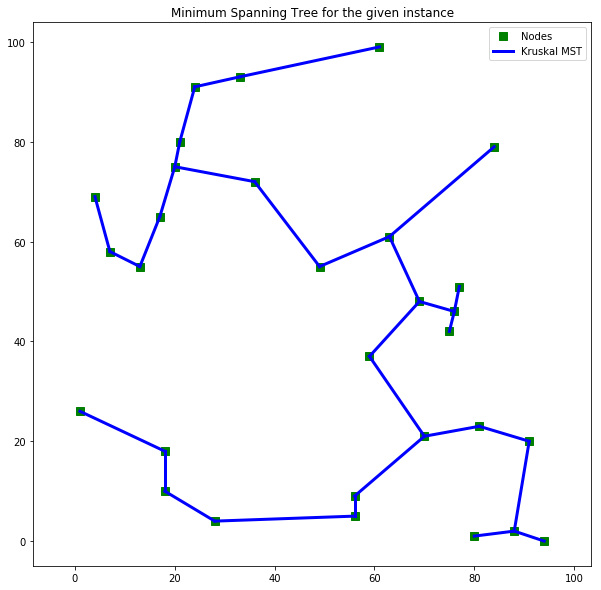

In [7]:
node_loc_x = np.array(node_loc).T[0]
node_loc_y = np.array(node_loc).T[1]

plt.figure(figsize=(10,10))
plt.plot(node_loc_x, node_loc_y, 'gs', markersize=8)

# Plotting the MST solution
def func_connect_points(node_loc_x,node_loc_y,p1,p2):
    x1, x2 = node_loc_x[p1], node_loc_x[p2]
    y1, y2 = node_loc_y[p1], node_loc_y[p2]
    plt.plot([x1,x2], [y1,y2], color='blue', linewidth=3, linestyle='-')

for i in MST_edges:
    func_connect_points(node_loc_x, node_loc_y, i[0],i[1])

plt.axis('equal')
plt.legend(['Nodes','Kruskal MST'], loc='best')
plt.title('Minimum Spanning Tree for the given instance')
plt.show()

In [8]:
print('\nSet of edges resulting in an MST: ' + str(MST_edges),
      '\nCost of the MST: '
     )


Set of edges resulting in an MST: [[13, 24], [3, 6], [6, 18], [15, 25], [26, 27], [9, 20], [6, 16], [5, 17], [22, 27], [4, 12], [2, 25], [8, 29], [2, 9], [28, 29], [4, 15], [20, 23], [5, 7], [14, 16], [1, 16], [14, 21], [10, 25], [8, 27], [24, 28], [17, 19], [1, 28], [10, 21], [11, 14], [7, 13], [0, 12]] 
Cost of the MST: 


#### MST + NN Plot

NameError: name 'tour_order' is not defined

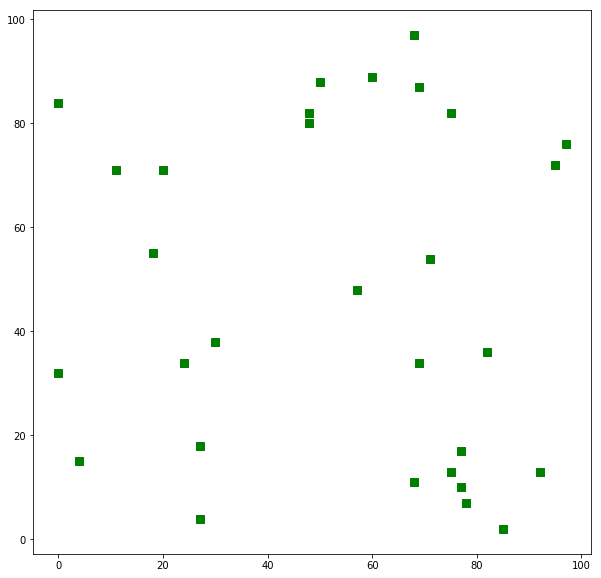

In [9]:
import matplotlib.pyplot as plt

node_loc_x = np.array(node_loc).T[0]
node_loc_y = np.array(node_loc).T[1]

plt.figure(figsize=(10,10))
plt.plot(node_loc_x, node_loc_y, 'gs', markersize=8)

# Plotting the Nearest Neighbour Heuristic Solution
def func_connect_points_TSP_NN(node_loc_x,node_loc_y,p1,p2):
    x1, x2 = node_loc_x[p1], node_loc_x[p2]
    y1, y2 = node_loc_y[p1], node_loc_y[p2]
    plt.plot([x1,x2],[y1,y2],'--k')

for i in range(0,len(tour_order)-1):
    func_connect_points_TSP_NN(node_loc_x, node_loc_y, tour_order[i],tour_order[i+1])

# Plotting the MST solution
def func_connect_points(node_loc_x,node_loc_y,p1,p2):
    x1, x2 = node_loc_x[p1], node_loc_x[p2]
    y1, y2 = node_loc_y[p1], node_loc_y[p2]
    plt.plot([x1,x2], [y1,y2], color='blue', linewidth=3, linestyle='-')

for i in MST_edges:
    func_connect_points(node_loc_x, node_loc_y, i[0],i[1])

plt.axis('equal')
plt.legend(['Nodes', 'TSP-NN', 'Kruskal MST'], loc='best')
plt.show()

## Shortest Path Problem (incomplete)

### Topological Sorting

In [16]:
def func_topological_sorting(df_ts, start_node):
    next_node = start_node
    topological_sorting = [next_node]
    current_nodes = [0]
    init_while = 1
    df_ts_func = df_ts.copy()
    # This while loop will execute until the current list is empty, which means that there are no more further nodes to explore
    while len(current_nodes)>0:

        # If statement to erase temporally valid length of current_nodes
        if init_while == 1:
                init_while = 0
                current_nodes.pop()

        # Check the outgoing arcs from node i
        for (i,j) in enumerate(df_ts_func.loc[next_node]):
                if np.isnan(j) == False:
                    if i not in current_nodes:
                        current_nodes.append(i)
                    # Deleting backward arcs in the matrix
                    df_ts_func.iloc[i,next_node] = np.nan
                    # Delete arcs that visit the node
                    df_ts_func.iloc[next_node,i] = np.nan

        # Determine which node has already been fully explored by checking the sum of its incoming arcs
        for loc,node in enumerate(current_nodes):
            if df_ts_func[node].sum()==0:
                next_node = node
                current_nodes.pop(loc)
                topological_sorting.append(next_node)
                break
    return topological_sorting

#### Comprobation instances

In [17]:
# Exercise 2.1
df_shrtst_pth = pd.DataFrame(data=[
    [np.nan,np.nan,10,1,5,np.nan,np.nan,4],
    [np.nan,np.nan,np.nan,np.nan,3,np.nan,np.nan,np.nan],
    [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan],
    [np.nan,5,3,np.nan,6,np.nan,2,2],
    [np.nan,np.nan,7,np.nan,np.nan,1,np.nan,np.nan],
    [np.nan,np.nan,2,np.nan,np.nan,np.nan,np.nan,np.nan],
    [np.nan,np.nan,6,np.nan,4,5,np.nan,np.nan],
    [np.nan,np.nan,5,np.nan,np.nan,np.nan,np.nan,np.nan]
])

df_ts = df_shrtst_pth/df_shrtst_pth
df_ts

,0,1,2,3,4,5,6,7
0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,1.0
1,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0
4,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN
5,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN
7,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [18]:
# Slide 29 - 2.Transportation_shortest_path_part1_screen
# df shortest path
df_shrtst_pth_1 = pd.DataFrame(data=[
    [np.nan,2,8,5,np.nan,np.nan,np.nan],
    [2,np.nan,7,2,8,np.nan,np.nan],
    [np.nan,np.nan,np.nan,np.nan,3,6,4],
    [np.nan,np.nan,np.nan,np.nan,np.nan,12,np.nan],
    [np.nan,np.nan,np.nan,np.nan,np.nan,3,7],
    [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,2],
    [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
])

df_ts_1 = df_shrtst_pth_1/df_shrtst_pth_1
df_ts_1

,0,1,2,3,4,5,6
0,NaN,1.0,1.0,1.0,NaN,NaN,NaN
1,1.0,NaN,1.0,1.0,1.0,NaN,NaN
2,NaN,NaN,NaN,NaN,1.0,1.0,1.0
3,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,NaN,NaN,NaN,NaN,NaN,1.0,1.0
5,NaN,NaN,NaN,NaN,NaN,NaN,1.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Pulling Algorithm

In [19]:
def func_pulling_algo(df_shrtst_pth_func, top_sorting_func):
    # Creating the pulling algorithm dataframe
    df_pulling = pd.DataFrame(data={'Node_j':[],'Backward_star_j':[],'dij_plus_cij':[],'dj':[],'pred_j':[]})

    # Looping through the nodes in topological order
    for j in range(0,len(top_sorting_func)):
        # Initializing the starting node
        if j == 0:
            df_row = pd.Series(data=[top_sorting_func[j],np.nan,np.nan,0,np.nan], 
                       index=['Node_j','Backward_star_j','dij_plus_cij','dj','pred_j'], name=None)
            df_pulling = df_pulling.append(df_row,ignore_index=True)

        # Iterating through all the other nodes
        else:
            # Obtaining list of arcs (backward star) that visit node j
            incoming_arcs = [[i,top_sorting_func[j],c] for [i,c] in enumerate(df_shrtst_pth_func[top_sorting_func[j]]) if np.isnan(c)==False]
            # Obtaining the cumulative distance from node i = d(i) + c_ij
            dij_plus_cijs = [[float(df_pulling[df_pulling['Node_j']==arc[0]]['dj']+arc[2]),arc[0]] for arc in incoming_arcs]
            # Obtaining the smallest distance, which will become d(j)
            dj = min(dij_plus_cijs)[0]
            # Obtaining the predecesor of node j, which is the one with the smallest d(i) + c_ij
            pred_j = min(dij_plus_cijs)[1]
            # Creating the row to append to the dataframe
            df_row = pd.Series(data=[top_sorting_func[j],incoming_arcs,dij_plus_cijs,dj,pred_j],
                              index=['Node_j','Backward_star_j','dij_plus_cij','dj','pred_j'], name=None)
            df_pulling = df_pulling.append(df_row,ignore_index=True)
    
    return df_pulling

In [20]:
func_pulling_algo(df_shrtst_pth_1,func_topological_sorting(df_ts_1,0))

,Node_j,Backward_star_j,dij_plus_cij,dj,pred_j
0,0.0,NaN,NaN,0.0,NaN
1,1.0,"[[0, 1, 2.0]]","[[2.0, 0]]",2.0,0.0
2,2.0,"[[0, 2, 8.0], [1, 2, 7.0]]","[[8.0, 0], [9.0, 1]]",8.0,0.0
3,3.0,"[[0, 3, 5.0], [1, 3, 2.0]]","[[5.0, 0], [4.0, 1]]",4.0,1.0
4,4.0,"[[1, 4, 8.0], [2, 4, 3.0]]","[[10.0, 1], [11.0, 2]]",10.0,1.0
5,5.0,"[[2, 5, 6.0], [3, 5, 12.0], [4, 5, 3.0]]","[[14.0, 2], [16.0, 3], [13.0, 4]]",13.0,4.0
6,6.0,"[[2, 6, 4.0], [4, 6, 7.0], [5, 6, 2.0]]","[[12.0, 2], [17.0, 4], [15.0, 5]]",12.0,2.0


In [21]:
func_pulling_algo(df_shrtst_pth,func_topological_sorting(df_ts,0))

,Node_j,Backward_star_j,dij_plus_cij,dj,pred_j
0,0.0,NaN,NaN,0.0,NaN
1,3.0,"[[0, 3, 1.0]]","[[1.0, 0]]",1.0,0.0
2,7.0,"[[0, 7, 4.0], [3, 7, 2.0]]","[[4.0, 0], [3.0, 3]]",3.0,3.0
3,1.0,"[[3, 1, 5.0]]","[[6.0, 3]]",6.0,3.0
4,6.0,"[[3, 6, 2.0]]","[[3.0, 3]]",3.0,3.0
5,4.0,"[[0, 4, 5.0], [1, 4, 3.0], [3, 4, 6.0], [6, 4,...","[[5.0, 0], [9.0, 1], [7.0, 3], [7.0, 6]]",5.0,0.0
6,5.0,"[[4, 5, 1.0], [6, 5, 5.0]]","[[6.0, 4], [8.0, 6]]",6.0,4.0
7,2.0,"[[0, 2, 10.0], [3, 2, 3.0], [4, 2, 7.0], [5, 2...","[[10.0, 0], [4.0, 3], [12.0, 4], [8.0, 5], [9....",4.0,3.0


In [26]:
start_node = 0
next_node = start_node
topological_sorting = [next_node]
current_nodes = [0]
init_while = 1
df_ts_func = df_ts_djkstra.copy()
df_ts_func = pd.DataFrame(np.triu(df_ts_func)).replace(0,np.nan)
# This while loop will execute until the current list is empty, which means that there are no more further nodes to explore
#while len(current_nodes)>0:
for i in range(0,10):
    # If statement to erase temporally valid length of current_nodes
    if init_while == 1:
            init_while = 0
            current_nodes.pop()

    # Check the outgoing arcs from node i
    for (i,j) in enumerate(df_ts_func.loc[next_node]):
            if np.isnan(j) == False:
                if i not in current_nodes:
                    current_nodes.append(i)
                # Deleting backward arcs in the matrix
                df_ts_func.iloc[i,next_node] = np.nan
                # Delete arcs that visit the node
                df_ts_func.iloc[next_node 
                                ,i] = np.nan

    # Determine which node has already been fully explored by checking the sum of its incoming arcs
    for loc,node in enumerate(current_nodes):
        if df_ts_func[node].sum()==0:
            next_node = node
            current_nodes.pop(loc)
            topological_sorting.append(next_node)
            break

### <a name="Dijkstra"></a><weak>Dijkstra for another day...</weak>

In [12]:
# Dijkstra Algorithm
# Originally we had a complete graph, the problem would be too boring if we solve it because you could simply use each connection, so we will
# create a subset of edges by multiplying the original distance matrix by a matrix of the same size containing random 0 and 1, which will
# lead to a subset of edges available. Though very unlikely, this procedure could lead to a node being completely isolated. Try to correct that.

df_dist_random = pd.DataFrame(data=np.random.randint(0,2,num_of_nodes**2).reshape(num_of_nodes,num_of_nodes))
# To delete edges in both directions i,j and j,i we have to perform : "Copy upper triangle to lower triangle"
# X = X + X.T - np.diag(np.diag(X))
df_dijkstra = (df_dist * pd.DataFrame(data = np.array(df_dist_random) + np.array(df_dist_random).T - np.diag(np.diag(np.array(df_dist_random)))))/2
df_dijkstra.replace(to_replace = 0.00, value=np.nan, inplace=True)

In [13]:
df_dijkstra

,0,1,2,3,4,5,6
0,NaN,NaN,1.000000,31.036269,32.101402,19.906029,40.610959
1,NaN,NaN,47.707442,29.261750,43.011626,30.761177,46.010868
2,1.000000,47.707442,NaN,30.037477,63.007936,18.927493,NaN
3,31.036269,29.261750,30.037477,NaN,NaN,12.747549,21.023796
4,32.101402,43.011626,63.007936,NaN,NaN,21.500000,NaN
5,19.906029,30.761177,18.927493,12.747549,21.500000,NaN,21.023796
6,40.610959,46.010868,NaN,21.023796,NaN,21.023796,NaN


In [29]:
# This approach could lead to connected components, we should then create a routine that checks this and in case it's true join them


In [30]:
# New edge set:
edge_set_dijkstra = []
for i in range(0,len(df_dijkstra)):
    for j in range(0,len(df_dijkstra)):
        if (np.isnan(df_dijkstra.loc[i,j]) != True): # and ([j,i] not in edge_set_dijkstra):
            edge_set_dijkstra.append([i,j])

In [31]:
len(edge_set_dijkstra)

30

In [32]:
sum(df_dijkstra.isna()+1-1)+1

22

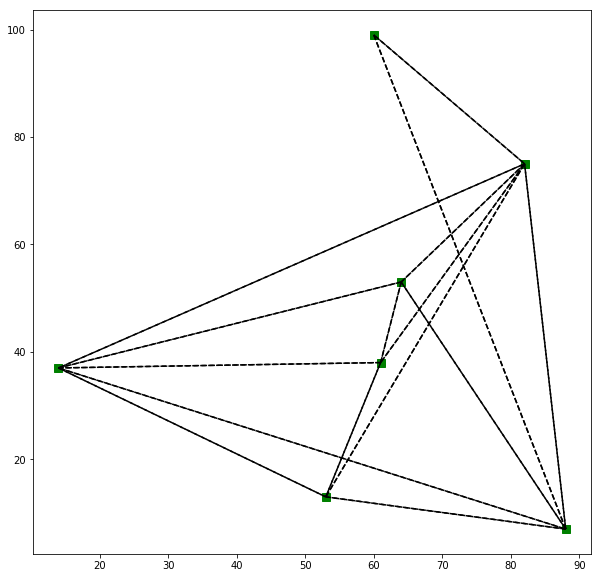

In [33]:
import matplotlib.pyplot as plt

node_loc_x = np.array(node_loc).T[0]
node_loc_y = np.array(node_loc).T[1]

plt.figure(figsize=(10,10))
plt.plot(node_loc_x, node_loc_y, 'gs', markersize=8)

# Plotting the Nearest Neighbour Heuristic Solution
def func_connect_points_TSP_NN(node_loc_x,node_loc_y,p1,p2):
    x1, x2 = node_loc_x[p1], node_loc_x[p2]
    y1, y2 = node_loc_y[p1], node_loc_y[p2]
    plt.plot([x1,x2],[y1,y2],'--k')

for i in range(0,len(edge_set_dijkstra)):
    func_connect_points_TSP_NN(node_loc_x, node_loc_y, edge_set_dijkstra[i][0],edge_set_dijkstra[i][1])

In [79]:
# Complete edge set: 
edge_set_dijkstra = []
for i in range(0,len(df_dijkstra)):
    for j in range(0,len(df_dijkstra)):
        edge_set_dijkstra.append([i,j])

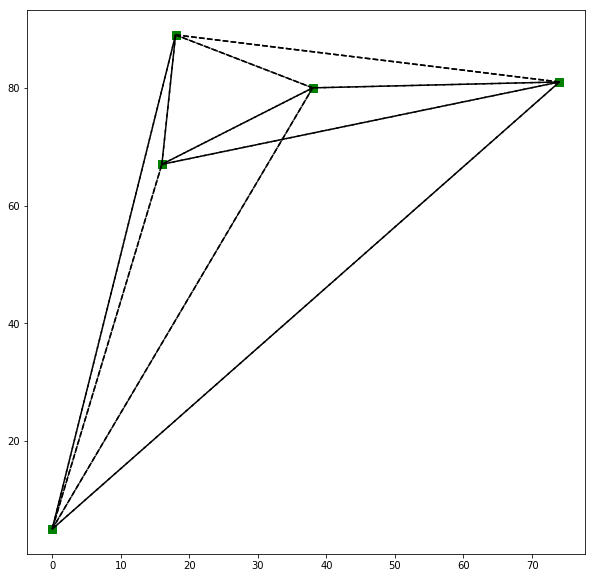

In [80]:
import matplotlib.pyplot as plt

node_loc_x = np.array(node_loc).T[0]
node_loc_y = np.array(node_loc).T[1]

plt.figure(figsize=(10,10))
plt.plot(node_loc_x, node_loc_y, 'gs', markersize=8)

# Plotting the Nearest Neighbour Heuristic Solution
def func_connect_points_TSP_NN(node_loc_x,node_loc_y,p1,p2):
    x1, x2 = node_loc_x[p1], node_loc_x[p2]
    y1, y2 = node_loc_y[p1], node_loc_y[p2]
    plt.plot([x1,x2],[y1,y2],'--k')

for i in range(0,len(edge_set_dijkstra)):
    func_connect_points_TSP_NN(node_loc_x, node_loc_y, edge_set_dijkstra[i][0],edge_set_dijkstra[i][1])

In [81]:
# Nice plot editing:
# https://www.pythoninformer.com/python-libraries/matplotlib/line-plots/


In [82]:
my_dict = {1:[10,[1,2]],2:[20,[1,2]],3:[3,[1,200]]}

In [83]:
sorted(my_dict, key=my_dict.get,reverse=True)

[2, 1, 3]

In [84]:
# Random node to begin:
# Edges leaving start node 
# Unvisited node list

In [85]:
df_dijkstra

,0,1,2,3,4
0,NaN,42.038673,21.931712,NaN,25.553865
1,42.038673,NaN,NaN,53.037722,NaN
2,21.931712,NaN,NaN,28.284271,11.045361
3,NaN,53.037722,28.284271,NaN,29.832868
4,25.553865,NaN,11.045361,29.832868,NaN


In [86]:
random_start = np.random.randint(0,num_of_nodes)
random_start = 0

unvisited_nodes = [x for x in range(0,num_of_nodes)]
visited_nodes = []
neighbours_i = sorted([(j,i) for (i,j) in enumerate(df_dijkstra.iloc[0]) if np.isnan(j) != True], reverse=True)

In [87]:
neighbours_i

[(42.03867267171979, 1), (25.553864678361276, 4), (21.93171219946131, 2)]

In [88]:
unvisited_nodes

[0, 1, 2, 3, 4]

In [89]:
visited_nodes

[]

In [90]:
unvisited_nodes.remove(random_start)
visited_nodes.append(random_start)
for x in neighbours_i:
    unvisited_nodes.remove(x[1])
    visited_nodes.append(x[1])

In [91]:
# Create a dictionary
dict_dist = {x: np.inf for x in range(0,num_of_nodes)}
# Delete the start to avoid getting 0 as the minimal value later on 
dict_dist.pop(random_start)

# Update distance dictionary:
for j in neighbours_i:
    dict_dist[j[1]] = j[0]

In [92]:
dict_dist

{1: 42.03867267171979, 2: 21.93171219946131, 3: inf, 4: 25.553864678361276}

In [93]:
curr_node = neighbours_i.pop()

In [94]:
if curr_node[0]<dict_dist[curr_node[1]]:
    dict_dist[curr_node[1]] = curr_node[0]

In [95]:
dict_dist

{1: 42.03867267171979, 2: 21.93171219946131, 3: inf, 4: 25.553864678361276}

In [96]:
best_key = min(dict_dist, key=dict_dist.get)

In [97]:
best_key

2

In [98]:
dict_dist

{1: 42.03867267171979, 2: 21.93171219946131, 3: inf, 4: 25.553864678361276}

In [66]:
node_loc

[[38, 80], [0, 5], [18, 89], [74, 81], [16, 67]]

In [99]:
visited_nodes

[0, 1, 4, 2]

In [108]:
available_edges = 
next_node = df_dijkstra.loc[random_start].idxmin()

In [256]:
available_edges = {}
used_edges = []
curr_node = random_start

for iteration in range(0,10):    
    curr_series = df_dijkstra.loc[curr_node][df_dijkstra.loc[curr_node].isna()!=True]

    for (i,j) in zip(curr_series.index,curr_series):
        dict_key = str(curr_node) + ',' + str(i)
        available_edges[dict_key] = j

    if iteration >= 1:
        edge_to_del_rev = str(edge_to_del.split(',')[1]) + ',' + str(edge_to_del.split(',')[0])
        del(available_edges[edge_to_del_rev])
        
    available_edges_sorted_keys = sorted(available_edges, key=available_edges.get, reverse=True)
    edge_to_del = available_edges_sorted_keys.pop()
    used_edges.append(edge_to_del)
    curr_node = int(edge_to_del.split(',')[1])
    del(available_edges[edge_to_del])

In [257]:
available_edges

{'0,1': 42.03867267171979,
 '2,3': 28.284271247461902,
 '4,3': 29.832867780352597}

In [258]:
used_edges

['0,2', '2,4', '4,0', '0,2', '2,4', '4,0', '0,2', '2,4', '4,0', '0,2']

In [228]:
available_edges_sorted_keys

['0,1', '0,4']

In [229]:
edge_to_del_rev

'2,0'

In [243]:
#available_edges_sorted_keys.pop().split(',')[1]
curr_node = int(available_edges_sorted_keys[-1].split(',')[1])
curr_series = df_dijkstra.loc[curr_node][df_dijkstra.loc[curr_node].isna()!=True]

for (i,j) in zip(curr_series.index,curr_series):
    dict_key = str(curr_node) + ',' + str(i)
    available_edges[dict_key] = j
    
available_edges_sorted_keys = sorted(available_edges, key=available_edges.get, reverse=True)

In [196]:
available_edges

{'0,1': 42.03867267171979,
 '0,2': 21.93171219946131,
 '0,4': 25.553864678361276,
 '2,0': 21.93171219946131,
 '2,3': 28.284271247461902,
 '2,4': 11.045361017187261}

In [224]:
start_to_node_dist = {i:j for i,j in zip(df_dijkstra.loc[curr_node].index, df_dijkstra.loc[curr_node])}
for i in start_to_node_dist:
    if np.isnan(start_to_node_dist[i]) == True:
        start_to_node_dist[i] = np.inf
        
# Delete the start to avoid getting 0 as the minimal value later on 
start_to_node_dist.pop(random_start)

# Update distance dictionary:
#for j in available_edges:
#    start_to_node_dist[j[1]] = j[0]

inf

In [225]:
start_to_node_dist

{1: 42.03867267171979, 2: 21.93171219946131, 3: inf, 4: 25.553864678361276}

True

In [238]:
curr_node

4

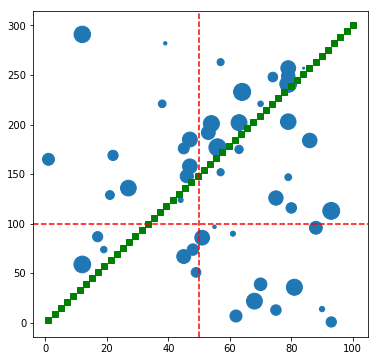

In [373]:
# Satish Plot
df_for_2plots = pd.DataFrame(data=[np.linspace(1,100,50),np.linspace(1,100,50)*3,np.random.randint(0,100,50),np.random.randint(0,300,50),
                  np.random.randint(0,300,50)]).transpose().rename({0:'x_1',1:'y_1',2:'x',3:'y',4:'profit'},axis=1)

plt.figure(figsize=(6,6))
#plt.scatter(df_for_2plots['x'], df_for_2plots['y'], 'gs', markersize=df_for_2plots['profit'])
plt.scatter(df_for_2plots['x'], df_for_2plots['y'], df_for_2plots['profit'])
plt.plot(df_for_2plots['x_1'], df_for_2plots['y_1'], 'gs')
#plt.plot(df_for_2plots['x_1'], df_for_2plots['y_1'], 'gs')
plt.axhline(y=100, color='r', linestyle='--')
plt.axvline(x=50, color='r', linestyle='--')

In [375]:
1.4+2+2.2+2.2+2.8+2.8+3.2+3.2+3.6+4.2+7.1+11.2

45.89999999999999

In [14]:
df_dijkstra

,0,1,2,3,4,5,6
0,NaN,NaN,1.000000,31.036269,32.101402,19.906029,40.610959
1,NaN,NaN,47.707442,29.261750,43.011626,30.761177,46.010868
2,1.000000,47.707442,NaN,30.037477,63.007936,18.927493,NaN
3,31.036269,29.261750,30.037477,NaN,NaN,12.747549,21.023796
4,32.101402,43.011626,63.007936,NaN,NaN,21.500000,NaN
5,19.906029,30.761177,18.927493,12.747549,21.500000,NaN,21.023796
6,40.610959,46.010868,NaN,21.023796,NaN,21.023796,NaN


In [15]:
df_ts_djkstra = df_dijkstra/df_dijkstra
df_ts_djkstra

,0,1,2,3,4,5,6
0,NaN,NaN,1.0,1.0,1.0,1.0,1.0
1,NaN,NaN,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,NaN,1.0,1.0,1.0,NaN
3,1.0,1.0,1.0,NaN,NaN,1.0,1.0
4,1.0,1.0,1.0,NaN,NaN,1.0,NaN
5,1.0,1.0,1.0,1.0,1.0,NaN,1.0
6,1.0,1.0,NaN,1.0,NaN,1.0,NaN


## Construction Heuristics for the TSP

### Nearest Neighbour Heuristic for the TSP

In [9]:
# Construction Heuristic : Tour Creation through the Nearest Neighbour Heuristic

def func_obtain_NN(df_dist):
    #global tour_dist, tour_order
    
    # Declaring all the variables needed
    # Start in any random node
    num_of_nodes = len(df_dist)
    tour_start = np.random.randint(0,num_of_nodes)
    nodes_to_visit = num_of_nodes-1
    current_node = tour_start
    
    # Creating two lists which will contain the distance lengths and the tour itself
    tour_dist = []
    tour_order = []
    df_dist_edit = df_dist.copy()
    
    # Iteration through all nodes
    while nodes_to_visit>0:
        # Obtaining and appending the min distance depending on which node you are currently
        current_distance = df_dist_edit[current_node][np.argmin(df_dist_edit[current_node])]
        tour_dist.append(current_distance)

        # Appending the current node to the tour
        tour_order.append(current_node)

        # Obtaning next node to visit and updating respective values, "erase" the corresponding j,i complete row to avoid a cycle
        previous_node = current_node
        df_dist_edit.iloc[current_node] = np.nan
        current_node = np.argmin(df_dist_edit[previous_node])
        nodes_to_visit -= 1
        
        # Close the tour
        if nodes_to_visit==0:
            tour_order.append(current_node)
            tour_order.append(tour_start)
            tour_dist.append(df_dist.loc[current_node,tour_start])
            
    tour_edges = [[tour_order[i],tour_order[i+1]] for i in range(0,len(tour_order)-1)]
    
    return tour_dist,tour_edges,tour_order

In [10]:
nearest_neighbour_results = func_obtain_NN(df_dist)

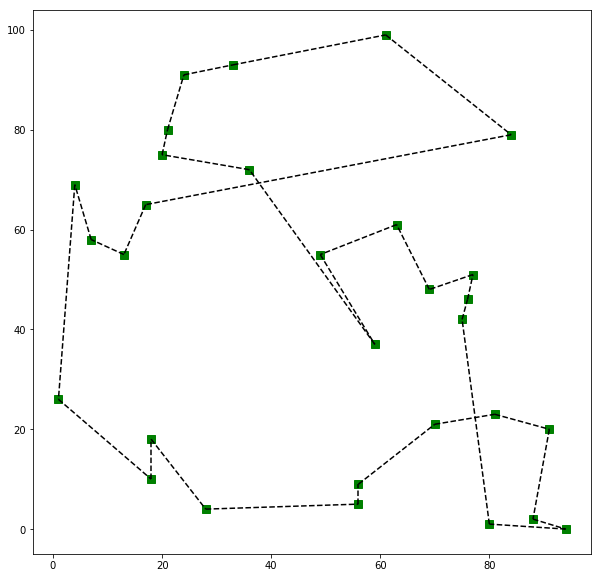

In [11]:
import matplotlib.pyplot as plt

node_loc_x = np.array(node_loc).T[0]
node_loc_y = np.array(node_loc).T[1]

plt.figure(figsize=(10,10))
plt.plot(node_loc_x, node_loc_y, 'gs', markersize=8)

# Plotting the Nearest Neighbour Heuristic Solution
def func_connect_points_TSP_NN(node_loc_x,node_loc_y,p1,p2):
    x1, x2 = node_loc_x[p1], node_loc_x[p2]
    y1, y2 = node_loc_y[p1], node_loc_y[p2]
    plt.plot([x1,x2],[y1,y2],'--k')

for i in range(0,len(nearest_neighbour_results[2])-1):
    func_connect_points_TSP_NN(node_loc_x, node_loc_y, nearest_neighbour_results[2][i],nearest_neighbour_results[2][i+1])

### Savings Heuristic for the TSP

In [12]:
def func_savings_heuristic(df_dist_savings):
    #global cc_i_id, cc_j_id
    cc_i_id, cc_j_id = 0,0
    ## Subroutine 1: Creating the connected components subroutine, which will create a component for each independent tour that arises given 
    ## the saving that has been selected, this is necessary to ensure that if two independent tours arise, we should be able to join them in  
    ## case it is required. A troublesome but mandatory implementation to ensure feasibility.
    connected_components=[]
    def subroutine_connected_components(edge, connected_components):
        #edge = current_sij[1]
        if len(connected_components)==0:
            connected_components.append(edge)
        else:
            edge_counter = 0
            for e_comp,comp in enumerate(connected_components):
                for e,node in enumerate(edge):  
                    if node in comp:
                        edge_counter += 1
                        insert_pos = (1 if e==0 else 0)
                        e_comp_insert = e_comp
                        if e == 0:
                            e_comp_node_i = e_comp
                        if e == 1:
                            e_comp_node_j = e_comp
            if edge_counter==1:
                connected_components[e_comp_insert].append(edge[insert_pos])
            elif edge_counter==0:
                connected_components.append(edge)
            else:# e_comp_node_i!=e_comp_node_j:
                if e_comp_node_i > e_comp_node_j:
                    first_to_remove, second_to_remove = e_comp_node_i, e_comp_node_j
                else:
                    first_to_remove, second_to_remove = e_comp_node_j, e_comp_node_i
                merged_cc = (connected_components[first_to_remove]+connected_components[second_to_remove])
                connected_components.remove(connected_components[first_to_remove])
                connected_components.remove(connected_components[second_to_remove])
                connected_components.insert(0,merged_cc)
        return connected_components

    # Subroutine 2: Reordering the tour edges because the order of the savings is not necessarily in a "tour order" fashion
    def subroutine_reorder_edges(tour_edges):
        tour_edges_for_order = tour_edges.copy()
        begin = tour_edges_for_order.pop(0)
        tour_edges = [begin]
        curr_end = begin[1]
        while len(tour_edges_for_order)>0:
            for e,i in enumerate(tour_edges_for_order):
                if curr_end in i:
                    if i.index(curr_end) == 1:
                        tour_edges.append([i[1],i[0]])
                        curr_end = i[0]
                    else:
                        tour_edges.append(i)
                        curr_end = i[1]
                    tour_edges_for_order.pop(e)
        return tour_edges

    # By default it is the first node but could change to a random one
    # start_node = random.randint(0,num_of_nodes)
    #df_dist_savings = df_dist.copy()
    start_node = 0
    remaining_nodes = [x for x in range(0,len(df_dist_savings)) if x != start_node]
    savings = []
    tour_edges = []
    # Construct the savings list: to avoid unnecessary extra savings we iterate only on the upper triangle of the savings matrix and discard  
    # the nans, this approach is valid because it is a symmetrical matrix, if it were not then we should check for the whole matrix
    # (Upper and lower triangles except the diagonal)
    for e,i in enumerate(remaining_nodes):
        for j in remaining_nodes[e:]:
            if i!=j:
                # Saving sij
                sij = df_dist_savings[start_node][i] + df_dist_savings[start_node][j] - df_dist_savings[i][j]
                savings.append([sij,[i,j]])         
    # Sorting the savings in non increasing order
    savings = sorted(savings, reverse = True)

    # Creating the table containing the final results, which include the saving and its correspondent feasibility check
    df_savings = pd.DataFrame(data={'Largest_saving':[],'Value':[],'Not_end_node':[],'Cost_ij':[]})
    tour_length = 0
    explored_sijs = []

    # Checking all the savings until you complete the tour
    #for i in range(0,30):
    while tour_length<len(df_dist_savings)-2:
        # Obtaining the first element from the queue
        current_sij = savings.pop(0) #if savings else False
        feasibility_counter = 0
        # Checking for feasibility, if the node appears in the visited less than two times then it is still eligible to be selected because
        # it does not form add an edge from a middle node
        for i in current_sij[1]:
            if explored_sijs.count(i)<2:
                feasibility_counter += 1
        # Extra check # 1 for avoiding creation of subtours:
        check_1 = (1 if current_sij[1][0] in explored_sijs else 0)
        check_2 = (1 if current_sij[1][1] in explored_sijs else 0)
        feasibility_multiplier = (0 if (check_1+check_2)==2 else 1)
        # Extra check # 2: check whether the new added edge connects two different components (a.k.a. subtours)
        if feasibility_multiplier == 0:
            node_i, node_j = current_sij[1][0], current_sij[1][1]
            for e,cc in enumerate(connected_components):
                if node_i in cc:
                    cc_i_id = e
                if node_j in cc:
                    cc_j_id = e
                feasibility_multiplier = 1 if cc_i_id!=cc_j_id else 0

        if feasibility_counter*feasibility_multiplier == 2:
            for i in current_sij[1]:
                explored_sijs.append(i)
            # Creating the row and appending it to the savings dataframe
            df_row = pd.Series(data = [current_sij[1],current_sij[0],list(set(explored_sijs)),df_dist_savings[current_sij[1][0]][current_sij[1][1]]], 
                               index = ['Largest_saving','Value','Not_end_node','Cost_ij'], name=None)
            df_savings = df_savings.append(df_row, ignore_index = True)
            tour_length += 1
            # Executing the connected components subroutine
            node_to_add = current_sij[1]
            connected_components = subroutine_connected_components(node_to_add,connected_components)
            tour_edges.append(node_to_add)
        '''
        print('Explored sijs: ' + str(explored_sijs),
              '\ncurrent_sij: ' + str(current_sij[1]),
              '\nfeasibility counter: ' + str(feasibility_counter) + ' - ' + 'feasibility_multiplier:' + str(feasibility_multiplier),
              '\nConnected components: ' + str(connected_components),
             '\nTour length: ' + str(tour_length)
             )
             #'\ndf_saving: ', df_savings)
        display(df_savings)
        '''
    # Completing the savings Dataframe with the two missing edges to close the tour
    end_nodes = pd.DataFrame(pd.Series(explored_sijs).value_counts()).reset_index()
    end_nodes = list(end_nodes[end_nodes[0]==1]['index'])
    for end_node in end_nodes:
        df_row = pd.Series(data=[[start_node,end_node],0,'-',df_dist_savings[start_node][end_node]],
                           index = ['Largest_saving','Value','Not_end_node','Cost_ij'], name=None)
        df_savings = df_savings.append(df_row, ignore_index = True)

    tour_edges = [df_savings.iloc[i]['Largest_saving'][0:2] if len(df_savings.iloc[i]['Largest_saving'])>2 else df_savings.iloc[i]['Largest_saving'] for i in range(0,len(df_savings))]
    df_savings['Largest_saving'] = pd.Series(data=tour_edges)
    tour_edges = subroutine_reorder_edges(tour_edges)
    tour_order = [tour_edges[i][0] if i<len(tour_edges) else tour_edges[0][0] for i in range(0,len(tour_edges)+1)]
    tour_dist = df_savings['Cost_ij']

    return list(tour_dist),tour_edges,tour_order,df_savings
    #del(df_dist_savings)

In [13]:
savings_results = func_savings_heuristic(df_dist)

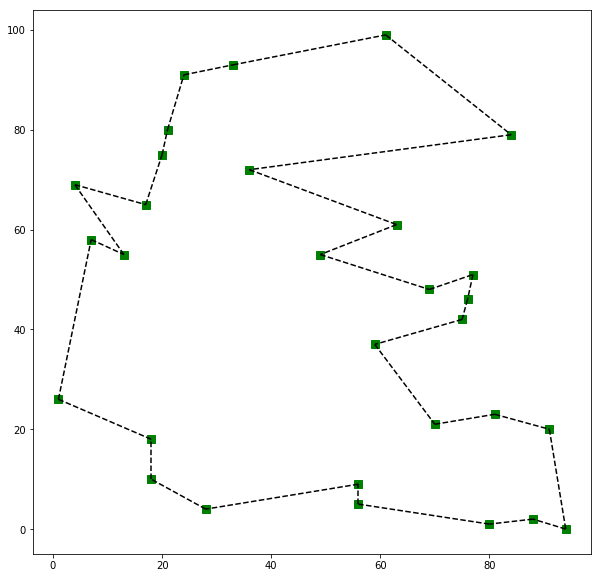

In [14]:
import matplotlib.pyplot as plt

node_loc_x = np.array(node_loc).T[0]
node_loc_y = np.array(node_loc).T[1]

plt.figure(figsize=(10,10))
plt.plot(node_loc_x, node_loc_y, 'gs', markersize=8)

# Plotting the Nearest Neighbour Heuristic Solution
def func_connect_points_TSP_NN(node_loc_x,node_loc_y,p1,p2):
    x1, x2 = node_loc_x[p1], node_loc_x[p2]
    y1, y2 = node_loc_y[p1], node_loc_y[p2]
    plt.plot([x1,x2],[y1,y2],'--k')

for i in range(0,len(savings_results[2])-1):
    func_connect_points_TSP_NN(node_loc_x, node_loc_y, savings_results[2][i],savings_results[2][i+1])

#### Test instances

In [15]:
# Instance from Exercise 7 Optimization of Logistics Systems
df_dist_ex7 = pd.DataFrame(data=[[np.nan,5.1,8.6,7.6,9.1,4.5,4.2,3.6,6.3,5.7,10.0,6.0],
                                    [5.1,np.nan,6.3,2.8,4.0,3.2,4.5,3.6,3.2,3.2,5.4,8.6],
                                    [8.6,6.3,np.nan,8.0,6.3,4.2,4.5,9.4,3.2,9.5,5.0,7.1],
                                    [7.6,2.8,8.0,np.nan,2.8,5.8,7.2,5.0,5.1,3.2,5.0,11.4],
                                    [9.1,4.0,6.3,2.8,np.nan,5.8,7.2,7.3,4.2,5.8,2.2,11.4],
                                    [4.5,3.2,4.2,5.8,5.8,np.nan,1.4,5.4,2.0,6.0,6.1,5.7],
                                    [4.2,4.5,4.5,7.2,7.2,1.4,np.nan,6.1,3.2,7.1,7.3,4.2],
                                    [3.6,3.6,9.4,5.0,7.3,5.4,6.1,np.nan,6.4,2.2,8.9,9.2],
                                    [6.3,3.2,3.2,5.1,4.2,2.0,3.2,6.4,np.nan,6.3,4.1,7.2],
                                    [5.7,3.2,9.5,3.2,5.8,6.0,7.1,2.2,6.3,np.nan,7.8,10.8],
                                    [10.0,5.4,5.0,5.0,2.2,6.1,7.3,8.9,4.1,7.8,np.nan,11.2],
                                    [6.0,8.6,7.1,11.4,11.4,5.7,4.2,9.2,7.2,10.8,11.2,np.nan]
])
df_dist_ex7.replace(to_replace=0.0,value=np.nan, inplace=True)
node_loc_slides = [[11,5],[6,4],[4,10],[4,2],[2,4],[7,7],[8,8],[9,2],[5,7],[7,1],[1,6],[11,11]]

IndexError: index 12 is out of bounds for axis 0 with size 12

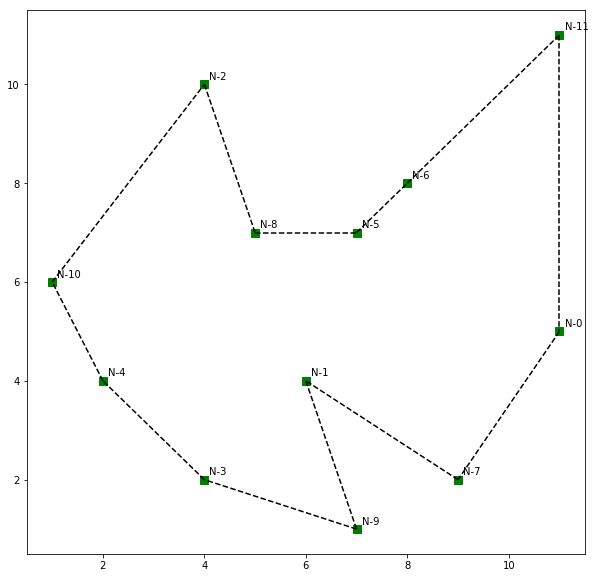

In [17]:
savings_results = func_savings_heuristic(df_dist_ex7)

import matplotlib.pyplot as plt

node_loc_x_slides = np.array(node_loc_slides).T[0]
node_loc_y_slides = np.array(node_loc_slides).T[1]

plt.figure(figsize=(10,10))
plt.plot(node_loc_x_slides, node_loc_y_slides, 'gs', markersize=8)

# Plotting the Nearest Neighbour Heuristic Solution
def func_connect_points_TSP_NN(node_loc_x_slides,node_loc_y_slides,p1,p2):
    x1, x2 = node_loc_x_slides[p1], node_loc_x_slides[p2]
    y1, y2 = node_loc_y_slides[p1], node_loc_y_slides[p2]
    plt.plot([x1,x2],[y1,y2],'--k')

for i in range(0,len(savings_results[2])-1):
    func_connect_points_TSP_NN(node_loc_x_slides, node_loc_y_slides, savings_results[2][i],savings_results[2][i+1])    
annotations = ['N-' + str(i) for i in range(0,num_of_nodes)]

for i, label in enumerate(annotations):
    plt.annotate(label, (node_loc_x_slides[i]+0.1, node_loc_y_slides[i]+0.1))

In [18]:
# To test the savings functions on the instance given in slide 145 from TSP part 2 OLS class with connected components 
node_loc_slides = [[1,9],[4,5],[0,5],[9,8],[7,7],[3,9],[6,0],[4,1],[9,7],[6,6]]
dist_list_slides = func_dist_calc(node_loc_slides)
df_dist_slides = pd.DataFrame(data=np.array(dist_list_slides).reshape(len(node_loc_slides),len(node_loc_slides)))
df_dist_slides.replace(to_replace=0.0,value=np.nan, inplace=True)

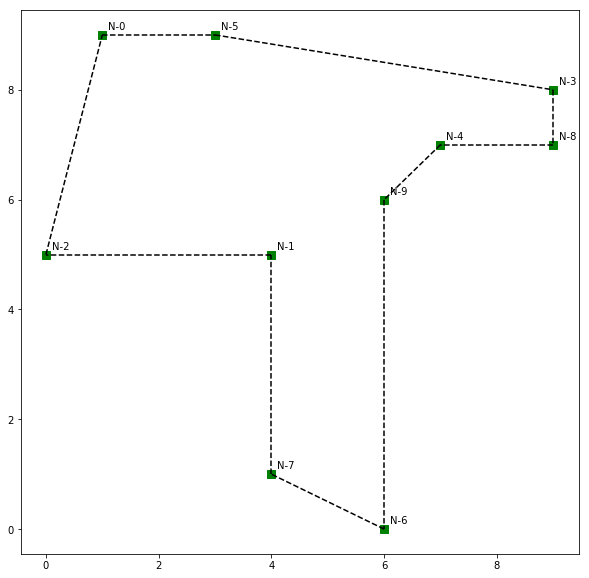

In [19]:
savings_results = func_savings_heuristic(df_dist_slides)

import matplotlib.pyplot as plt

node_loc_x_slides = np.array(node_loc_slides).T[0]
node_loc_y_slides = np.array(node_loc_slides).T[1]

plt.figure(figsize=(10,10))
plt.plot(node_loc_x_slides, node_loc_y_slides, 'gs', markersize=8)

# Plotting the Nearest Neighbour Heuristic Solution
def func_connect_points_TSP_NN(node_loc_x_slides,node_loc_y_slides,p1,p2):
    x1, x2 = node_loc_x_slides[p1], node_loc_x_slides[p2]
    y1, y2 = node_loc_y_slides[p1], node_loc_y_slides[p2]
    plt.plot([x1,x2],[y1,y2],'--k')

for i in range(0,len(savings_results[2])-1):
    func_connect_points_TSP_NN(node_loc_x_slides, node_loc_y_slides, savings_results[2][i],savings_results[2][i+1])
    
annotations = ['N-' + str(i) for i in range(0,len(node_loc_slides))]
for i, label in enumerate(annotations):
    plt.annotate(label, (node_loc_x_slides[i]+0.1, node_loc_y_slides[i]+0.1))

###### Connected components function with useful prints

In [189]:
#connected_components = []
#edges = df_savings['Largest_saving'][0:6].copy()
#edges = [[2,7],[1,7],[1,6],[4,5],[6,8],[3,9]]
for edge in edges:
    print(edge) 
    if len(connected_components)==0:
        connected_components.append(edge)
    else:
        edge_counter = 0
        for e_comp,comp in enumerate(connected_components):
            print('E_comp: ',e_comp)
            for e,node in enumerate(edge):
                if node in comp:
                    edge_counter += 1
                    #edge_counter = min(2,edge_counter)
                    insert_pos = (1 if e==0 else 0)
                    e_comp_insert = e_comp
                    if e == 0:
                        e_comp_node_i = e_comp
                    if e == 1:
                        e_comp_node_j = e_comp
                    #e_comp_node_j = e_comp #if e == 1 else 0
                    
                print(e,node, 'e_comp_node_i: ' ,e_comp_node_i, ' - ', 'e_comp_node_j: ', e_comp_node_j)
        if edge_counter==1:
            print(e_comp,' - ',insert_pos)
            connected_components[e_comp_insert].append(edge[insert_pos])
        elif e_comp_node_i!=e_comp_node_j:
            if e_comp_node_i > e_comp_node_j:
                first_to_remove, second_to_remove = e_comp_node_i, e_comp_node_j
            else:
                first_to_remove, second_to_remove = e_comp_node_j, e_comp_node_i
            merged_cc = (connected_components[first_to_remove]+connected_components[second_to_remove])
            connected_components.remove(connected_components[first_to_remove])
            connected_components.remove(connected_components[second_to_remove])
            connected_components.insert(0,merged_cc)
        else:#if edge_counter==2:
            #print(edge_counter,edge)
            connected_components.append(edge)
        print('edge counter: ',edge_counter)
    print(connected_components)

[2, 7]
[[2, 7]]
[1, 7]
E_comp:  0
0 1 e_comp_node_i:  1  -  e_comp_node_j:  0
1 7 e_comp_node_i:  1  -  e_comp_node_j:  0
0  -  0
edge counter:  1
[[2, 7, 1]]
[1, 6]
E_comp:  0
0 1 e_comp_node_i:  0  -  e_comp_node_j:  0
1 6 e_comp_node_i:  0  -  e_comp_node_j:  0
0  -  1
edge counter:  1
[[2, 7, 1, 6]]
[4, 5]
E_comp:  0
0 4 e_comp_node_i:  0  -  e_comp_node_j:  0
1 5 e_comp_node_i:  0  -  e_comp_node_j:  0
edge counter:  0
[[2, 7, 1, 6], [4, 5]]
[6, 8]
E_comp:  0
0 6 e_comp_node_i:  0  -  e_comp_node_j:  0
1 8 e_comp_node_i:  0  -  e_comp_node_j:  0
E_comp:  1
0 6 e_comp_node_i:  0  -  e_comp_node_j:  0
1 8 e_comp_node_i:  0  -  e_comp_node_j:  0
1  -  1
edge counter:  1
[[2, 7, 1, 6, 8], [4, 5]]
[3, 9]
E_comp:  0
0 3 e_comp_node_i:  0  -  e_comp_node_j:  0
1 9 e_comp_node_i:  0  -  e_comp_node_j:  0
E_comp:  1
0 3 e_comp_node_i:  0  -  e_comp_node_j:  0
1 9 e_comp_node_i:  0  -  e_comp_node_j:  0
edge counter:  0
[[2, 7, 1, 6, 8], [4, 5], [3, 9]]
[4, 8]
E_comp:  0
0 4 e_comp_node_i: 

### Christofides Heuristic for the TSP

---
#### Pseudocode for: Christofides tree heuristic

---
// Input: $(d_{ij}) \in \mathbb {R}^{nxn}$
    <br>
    DETERMINE MST $(V;T)$
    <br>
    IDENTIFY all nodes $U$ with odd degree
    <br>
    CALCULATE cost-minimum matching $M$ on subgraph induced by $U$
    <br>
    ADD $M$ to MST $(V;T)$
    <br>
    DETERMINE Euler tour $y$ in subgraph
    <br>
    DETERMINE tour $x$ from $y$ by removing nodes visited twice
    <br>
// Output: tour $x$

---


In [15]:
def func_christofides_heuristic(df_dist_chrstfds):

    # Defining the first subroutine which will create connected components
    connected_components_cc=[]
    def subroutine_connected_components_cc(edge_cc, connected_components_cc):
        #edge_cc = current_sij[1]
        if len(connected_components_cc)==0:
            connected_components_cc.append(edge_cc)
        else:
            edge_cc_counter = 0
            same_cc_counter_memory = 0
            for e_comp,comp in enumerate(connected_components_cc):
                same_cc_counter = 0
                for e,node in enumerate(edge_cc):  
                    if node in comp:
                        edge_cc_counter += 1
                        same_cc_counter += 1
                        insert_pos = (1 if e==0 else 0)
                        e_comp_insert = e_comp
                        if e == 0:
                            e_comp_node_i = e_comp
                        if e == 1:
                            e_comp_node_j = e_comp
                if same_cc_counter ==2:
                    same_cc_counter_memory = 2
                #print(edge_cc,' - ',edge_cc_counter,' - ',same_cc_counter, ' - ', same_cc_counter_memory)
            if edge_cc_counter==1:
                connected_components_cc[e_comp_insert].append(edge_cc[insert_pos])
            elif edge_cc_counter==0:
                connected_components_cc.append(edge_cc)
            elif edge_cc_counter==2 and same_cc_counter_memory==2:
                pass
            else:# e_comp_node_i!=e_comp_node_j:
                if e_comp_node_i > e_comp_node_j:
                    first_to_remove, second_to_remove = e_comp_node_i, e_comp_node_j
                else:
                    first_to_remove, second_to_remove = e_comp_node_j, e_comp_node_i
                merged_cc = (connected_components_cc[first_to_remove]+connected_components_cc[second_to_remove])
                connected_components_cc.remove(connected_components_cc[first_to_remove])
                connected_components_cc.remove(connected_components_cc[second_to_remove])
                connected_components_cc.insert(0,merged_cc)

        return connected_components_cc

    #df_dist_chrstfds = df_dist.copy()
    num_of_nodes = len(df_dist_chrstfds)
    df_dist_chrstfds.replace(to_replace=0.0,value=np.nan, inplace=True)
    MST_edges = func_Kruskal_MST(df_dist_chrstfds)

    # Determine nodes in the MST that have an odd degree
    # Create a list with the nodes contained in each edge
    nodes_edges = [node for edge in MST_edges for node in edge]
    nodes_odd_degree = []
    # Evaluate whether their degree is odd or even
    for (x,y) in zip(pd.Series(data=nodes_edges).value_counts().index,pd.Series(data=nodes_edges).value_counts()):
        if y%2 != 0:
            nodes_odd_degree.append(x)
    # We sort it to simplify edge comparison later on 
    nodes_odd_degree = sorted(nodes_odd_degree)

    # Importing Networkx, which is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of 
    # complex networks. This step is needed in order to apply their built solution for the max matching problem
    nx_citing = str('Aric A. Hagberg, Daniel A. Schult and Pieter J. Swart, “Exploring network structure, dynamics, and function using NetworkX”, in Proceedings of the 7th Python in Science Conference (SciPy2008), Gäel Varoquaux, Travis Vaught, and Jarrod Millman (Eds), (Pasadena, CA USA), pp. 11–15, Aug 2008')

    # Creating a new distance matrix only from the nodes of odd degree, changing it into nx format and plugging it to the max_weight_matching function
    nodes_odd_degree_ix = np.ix_(nodes_odd_degree, nodes_odd_degree)
    nx_graph = nx.from_numpy_array(-1 * np.array(df_dist_chrstfds)[nodes_odd_degree_ix])
    min_cost_matching_nx = max_weight_matching(nx_graph, maxcardinality=True)

    min_cost_matching = []
    for i in min_cost_matching_nx:
        min_cost_matching.append([nodes_odd_degree[i[0]],nodes_odd_degree[i[1]]])

    # Unite set of edges in the minimum spanning tree T ∪ minimal cost matching M to form an Eulerian multigraph 
    # Preprocessing of the edges to make that in M that were already in T flip orientation
    T_U_M = MST_edges + min_cost_matching
    new_T_U_M = []
    for i in T_U_M:
        if i in new_T_U_M:
            new_T_U_M.append([i[1],i[0]])
        else:
            new_T_U_M.append(i)
    T_U_M = new_T_U_M.copy()

    # Eulerian circuit / tour
    start_node = 0
    curr_node = int(start_node)
    next_node = 0
    holder,next_node_remove = 0,0
    euler_tour_edges = []
    while len(T_U_M)>0:
        #print('\n',T_U_M)
        curr_node = next_node
        # Obtaining current neighbour edges and nodes
        curr_neighbours_edges = [i for i in T_U_M if curr_node in i]
        curr_neighbours_nodes = list(pd.Series([i[0] if curr_node==i[1] else i[1] for i in curr_neighbours_edges]).unique())
        curr_neighbours_nodes.remove(next_node_remove) if holder==1 else curr_neighbours_nodes
        #print('Neighbour nodes: ' , curr_neighbours_nodes)
        # By convention the next node to visit if there are several candidates is the one with the lowest index
        next_node = min(curr_neighbours_nodes)
        edge_to_delete = ([curr_node,next_node] if [curr_node,next_node] in T_U_M else [next_node,curr_node])
        T_U_M.remove(edge_to_delete)
        
        # If we delete an edge that is a bridge edge, meaning that deleting it will lead to two connected components then we should avoid it 
        # and explore another option, in this implementation we first remove the edge, if later we found that it was a bridge then we restore
        # it into the set of edges and forbid that the next iteration considers that neighbour again, in this case denoted by the variable
        # "holder", that specifies if we have different connected components, and the variable "next_node_remove"
        connected_components=[]
        for edge in T_U_M:
            connected_components = subroutine_connected_components_cc(edge,connected_components)
        # Reordering the list because I DON'T KNOW WHY the connected components function 
        T_U_M = [T_U_M[i][0:2] if len(T_U_M[i])>2 else T_U_M[i] for i in range(0,len(T_U_M))]
        MST_edges = [MST_edges[i][0:2] if len(MST_edges[i])>2 else MST_edges[i] for i in range(0,len(MST_edges))]
        #print('T_U_M after cc: ', T_U_M)
        
        # This check ensures that the starting node which in this case should also be the end node is always present, mandatory otherwise
        # we would end up in a disconnected component
        feasibility_check = 0
        for i in range(0,len(connected_components)):
            if start_node not in connected_components[i]:
                feasibility_check += 1

        if (len(connected_components)>1) or feasibility_check==1:
            T_U_M.append(edge_to_delete)
            next_node_remove = next_node
            next_node = curr_node
            holder = 1
        else:
            holder = 0
            euler_tour_edges.append(edge_to_delete)

        #print(start_node,feasibility_check,connected_components)
        '''
        print('Curr_node: ', curr_node, 'Next_node: ',next_node,
              '\nedge_to_delete: ',edge_to_delete,
              #'\nNodes counts: ',str(pd.Series([node for edge in T_U_M for node in edge]).value_counts()),
              '\nCC: ', connected_components,
             '\nHolder: ', holder, ' next_node_remove: ', next_node_remove)
        '''

    # Creating the tour iterating over the edges of the euler tour
    euler_tour = [euler_tour_edges[0][1],euler_tour_edges[0][0]] if euler_tour_edges[0].index(start_node)== 1 else euler_tour_edges[0]
    for i in range(1,len(euler_tour_edges)):
        euler_tour.append(euler_tour_edges[i][1] if euler_tour[-1] == euler_tour_edges[i][0] else euler_tour_edges[i][0])

    # Deleting repeated nodes in the euler tour to form the new TSP tour and creating a list of its edges
    chrstfds_tour = []
    for i in euler_tour:
        if i not in chrstfds_tour:
            chrstfds_tour.append(i)
    chrstfds_edges = [[chrstfds_tour[i],chrstfds_tour[i+1]] if i < len(chrstfds_tour)-1 else [chrstfds_tour[-1],chrstfds_tour[0]] for i in range(0,len(chrstfds_tour))]
    chrstfds_dist = [df_dist_chrstfds.loc[edge[0],edge[1]] for edge in chrstfds_edges]
    #return tour_dist,tour_edges,tour_order
    return chrstfds_dist, chrstfds_edges, chrstfds_tour, MST_edges, min_cost_matching, euler_tour_edges, euler_tour

In [16]:
chrstfds_results = func_christofides_heuristic(df_dist_chrstfds=df_dist)

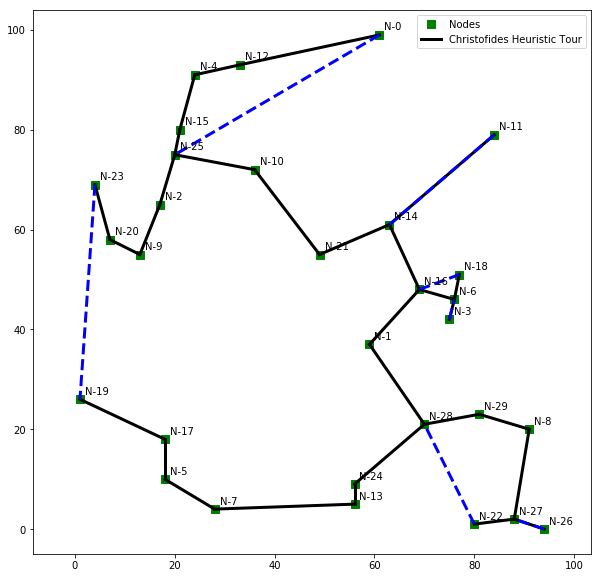

In [17]:
node_loc_x = np.array(node_loc).T[0]
node_loc_y = np.array(node_loc).T[1]

plt.figure(figsize=(10,10))
plt.plot(node_loc_x, node_loc_y, 'gs', markersize=8)

# Plotting the MST solution
def func_connect_points_MST(node_loc_x,node_loc_y,p1,p2):
    x1, x2 = node_loc_x[p1], node_loc_x[p2]
    y1, y2 = node_loc_y[p1], node_loc_y[p2]
    plt.plot([x1,x2], [y1,y2], color='black', linewidth=3, linestyle='-')
    
def func_connect_points_MCM(node_loc_x,node_loc_y,p1,p2):
    x1, x2 = node_loc_x[p1], node_loc_x[p2]
    y1, y2 = node_loc_y[p1], node_loc_y[p2]
    plt.plot([x1,x2], [y1,y2], color='blue', linewidth=3, linestyle='--')

for i in chrstfds_results[3]:
    func_connect_points_MST(node_loc_x, node_loc_y, i[0],i[1])
    
for i in chrstfds_results[4]:
    func_connect_points_MCM(node_loc_x, node_loc_y, i[0],i[1])

annotations = ['N-' + str(i) for i in range(0,len(df_dist))]
for i, label in enumerate(annotations):
    plt.annotate(label, (node_loc_x[i]+1, node_loc_y[i]+1))
plt.axis('equal')
plt.legend(['Nodes', 'Christofides Heuristic Tour'], loc='best')
plt.show()

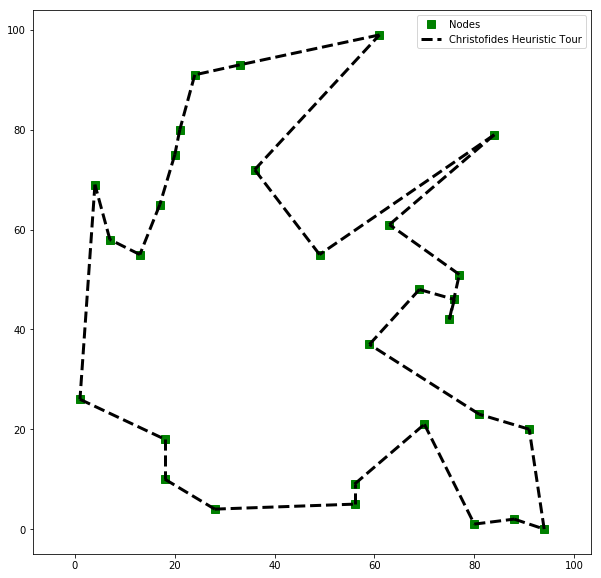

In [18]:
node_loc_x = np.array(node_loc).T[0]
node_loc_y = np.array(node_loc).T[1]

plt.figure(figsize=(10,10))
plt.plot(node_loc_x, node_loc_y, 'gs', markersize=8)

# Plotting the MST solution
def func_connect_points(node_loc_x,node_loc_y,p1,p2):
    x1, x2 = node_loc_x[p1], node_loc_x[p2]
    y1, y2 = node_loc_y[p1], node_loc_y[p2]
    plt.plot([x1,x2], [y1,y2], color='black', linewidth=3, linestyle='--')

for i in func_christofides_heuristic(df_dist_chrstfds=df_dist)[1]:
    func_connect_points(node_loc_x, node_loc_y, i[0],i[1])

plt.axis('equal')
plt.legend(['Nodes', 'Christofides Heuristic Tour'], loc='best')
plt.show()

### Heuristics Performance Comparison

In [19]:
# Joining any two points
def func_connect_points(node_loc, ax_loc, p1, p2):  
    node_loc_x = np.array(node_loc).T[0]
    node_loc_y = np.array(node_loc).T[1]
    ax[ax_loc].plot(node_loc_x, node_loc_y, 'gs', markersize=8)
    
    x1, x2 = node_loc_x[p1], node_loc_x[p2]
    y1, y2 = node_loc_y[p1], node_loc_y[p2]
    ax[ax_loc].plot([x1,x2], [y1,y2], color='black', linewidth=2, linestyle='--')

Text(0.5, 1.0, 'Christofides Heuristic | Cost: 500.16')

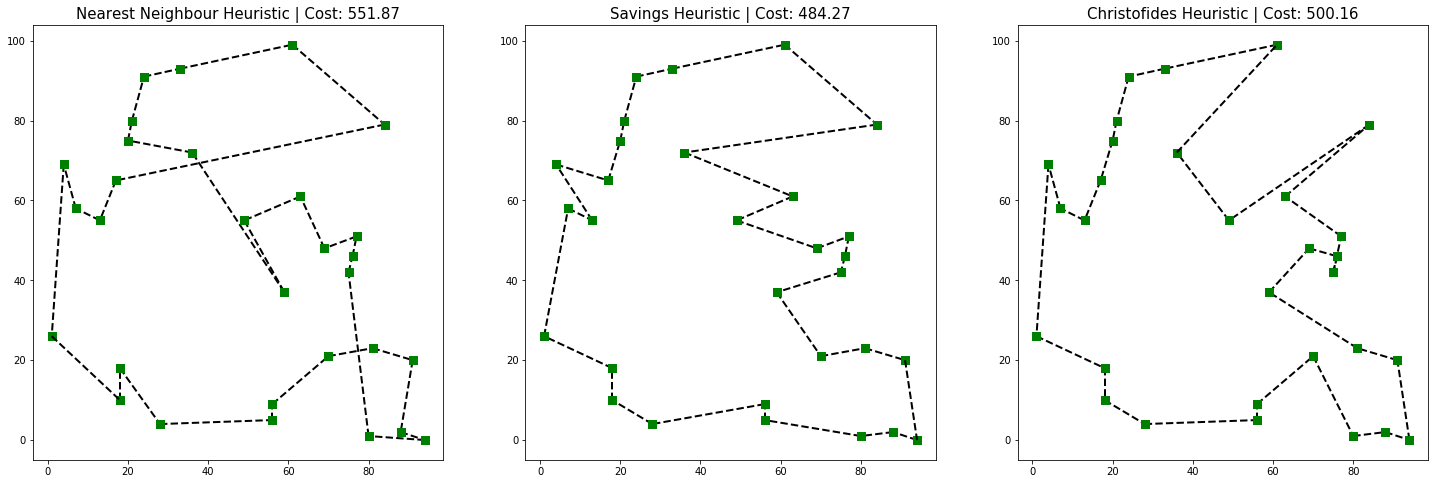

In [20]:
fig, ax = plt.subplots(1,3, figsize=(25,8), sharey=False)

# Plotting the Nearest Neighbour heuristic
for i in nearest_neighbour_results[1]:
    func_connect_points(node_loc, 0, i[0],i[1])
ax[0].set_title('Nearest Neighbour Heuristic | Cost: ' + "{:.2f}".format(sum(nearest_neighbour_results[0])), fontdict={'fontsize':15})

# Plotting the Savings heuristic
for i in savings_results[1]:
    func_connect_points(node_loc, 1, i[0],i[1])
ax[1].set_title('Savings Heuristic | Cost: ' + "{:.2f}".format(sum(savings_results[0])), fontdict={'fontsize':15})

# Plotting the Christofides heuristic
for i in chrstfds_results[1]:
    func_connect_points(node_loc, 2, i[0],i[1])
ax[2].set_title('Christofides Heuristic | Cost: ' + "{:.2f}".format(sum(chrstfds_results[0])), fontdict={'fontsize':15})

In [21]:
df_comparison_results = pd.DataFrame(data={'Iteration':[],'Instance_Size':[],'Instance':[],'Algorithm':[],'Performance':[],'Exec_Time':[],'Tour':[]})
for e,instance_size in enumerate(list(np.linspace(0,100,101)[5:])):
    # Creating a random instance
    num_of_nodes = int(instance_size)
    node_loc = create_nodes(num_of_nodes)
    dist_list = func_dist_calc(node_loc)
    df_dist = pd.DataFrame(data=np.array(dist_list).reshape(num_of_nodes,num_of_nodes))
    df_dist.replace(to_replace=0.0,value=np.nan, inplace=True)
    
    # Nearest Neighbour Heuristic
    begin_time = time.time()
    nearest_neighbour_results = func_obtain_NN(df_dist)
    exec_time = time.time()-begin_time
    df_row = pd.Series(data=[e,instance_size,node_loc,'NN',sum(nearest_neighbour_results[0]),exec_time,nearest_neighbour_results[1:3]],
                       index=['Iteration','Instance_Size','Instance','Algorithm','Performance','Exec_Time','Tour'], name=None)
    df_comparison_results = df_comparison_results.append(df_row, ignore_index=True)
    
    # Savings Heuristic
    begin_time = time.time()
    savings_results = func_savings_heuristic(df_dist)
    exec_time = time.time()-begin_time
    df_row = pd.Series(data=[e,instance_size,node_loc,'Savings',sum(savings_results[0]),exec_time,savings_results[1:3]],
                       index=['Iteration','Instance_Size','Instance','Algorithm','Performance','Exec_Time','Tour'], name=None)
    df_comparison_results = df_comparison_results.append(df_row,ignore_index=True)
    
    # Christofides Heuristic
    begin_time = time.time()
    chrstfds_results = func_christofides_heuristic(df_dist_chrstfds=df_dist)
    exec_time = time.time()-begin_time
    df_row = pd.Series(data=[e,instance_size,node_loc,'Christofides',sum(chrstfds_results[0]),exec_time,chrstfds_results[1:3]],
                       index=['Iteration','Instance_Size','Instance','Algorithm','Performance','Exec_Time','Tour'], name=None)
    df_comparison_results = df_comparison_results.append(df_row,ignore_index=True)

Text(0.5, 1.0, 'Run-time comparison between the algorithms for a given instance size')

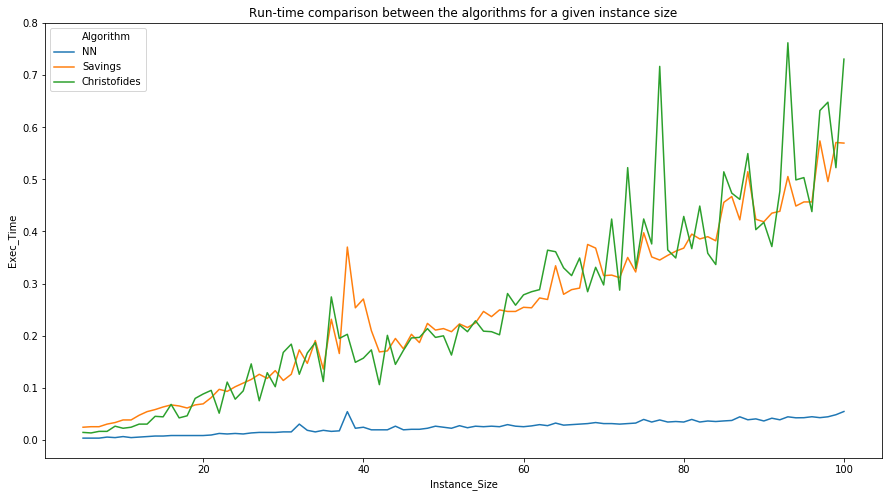

In [22]:
plt.figure(figsize=(15,8))
sns.lineplot(data=df_comparison_results, x='Instance_Size', y='Exec_Time', hue='Algorithm')
plt.title('Run-time comparison between the algorithms for a given instance size')

Text(0.5, 1.0, 'Average performance comparison (less is better because is the cost of a solution)')

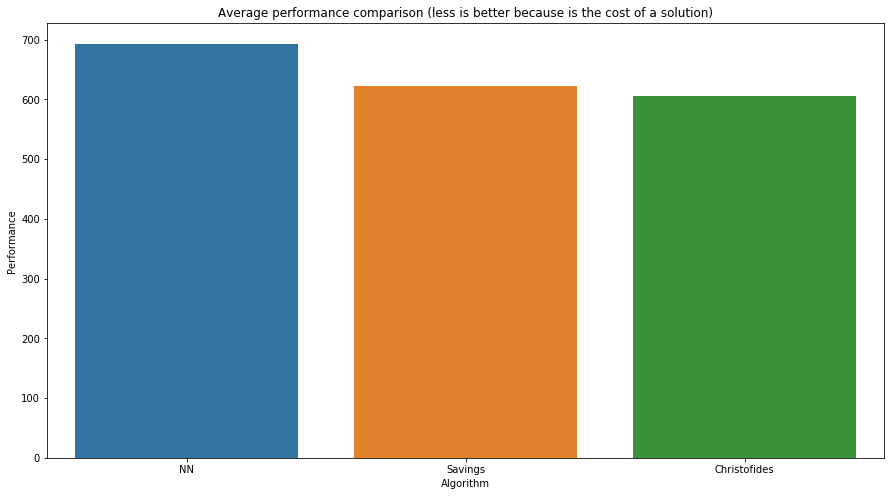

In [23]:
plt.figure(figsize=(15,8))
sns.barplot(data=df_comparison_results[['Algorithm','Performance']].groupby(by='Algorithm', as_index=False).mean().sort_values(by='Performance', ascending=False), 
             x='Algorithm', y='Performance')
plt.title('Average performance comparison (less is better because is the cost of a solution)')

Text(0.5, 1.0, 'Scatter plot')

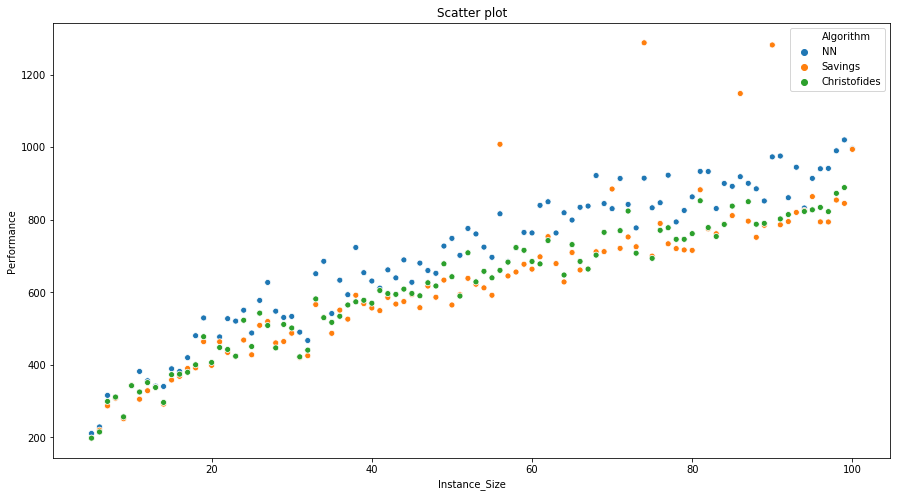

In [24]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=df_comparison_results, x='Instance_Size', y='Performance', hue='Algorithm')
plt.title('Scatter plot')

## Improvement Heuristics

### <a name="2Opt"></a><weak>Local Search: 2 opt operator</weak>

The search for improving neighbors can be designed in different ways:

- <u>First improvement</u>: Consecutively inspect the elements of the neighborhood (in a predefined order) and stop when the first improving neighbor is found

- <u>Best improvement</u>: Search the complete neighborhood and select the best improving neighbor (in general, not unique)

In [5]:
'''
num_of_nodes = 7
dist_list = func_dist_calc(create_nodes(num_of_nodes))
df_dist = pd.DataFrame(data=np.array(dist_list).reshape(num_of_nodes,num_of_nodes))
df_dist.replace(to_replace=0.0,value=np.nan, inplace=True)
construction_heuristic_solution = func_obtain_NN(df_dist,num_of_nodes)
func_twoopt_operator(df_dist, func_obtain_NN(df_dist,num_of_nodes), search_type='best')
'''
def func_twoopt_operator(df_dist, construction_heuristic_solution, search_type):
#for meg_it in [0]:
    gain_check = 1
    search_type = 'best'
    curr_tour_edges = construction_heuristic_solution[1].copy()
    tour_improvement = [construction_heuristic_solution[2]]
    gain_log = []
    while gain_check!=0:
    #for it in range(0,5):
        # 2 opt operator still we can save some innecesary calculations because half of them are symmetrical, how to do it efficiently?
        gains = []
        first_gain_counter = 0
        first_gain = [0,['null']]
        for i in range(0,len(curr_tour_edges)):
            # Creating the edges to explore list, which contains the current edge at the first position + the other edges that are not adyacent to it
            edges_to_explore = curr_tour_edges.copy()
            edges_to_explore.remove(curr_tour_edges[i])
            edges_to_explore.remove(curr_tour_edges[i-1])
            (edges_to_explore.remove(curr_tour_edges[0]) if i ==(len(curr_tour_edges)-1) else edges_to_explore.remove(curr_tour_edges[i+1]))
            edges_to_explore.insert(0,curr_tour_edges[i])
            curr_edge = edges_to_explore[0]

            # Fixing the current edge i and trying the different combination with the remaining edges to explore
            for j in edges_to_explore[1:]:  
                new_edges = [[curr_edge[0],j[0]],[curr_edge[1],j[1]]]
                # Calculating the gain resulting from the edge removal operation and appending it to the gainings list
                gain = (-df_dist.iloc[curr_edge[0],curr_edge[1]] #Removed edge 1
                        - df_dist.iloc[j[0],j[1]] # Removed edge 2
                        + df_dist.iloc[curr_edge[0],j[0]] # Inserted edge 1
                        + df_dist.iloc[curr_edge[1],j[1]]) # Inserted edge 2
                gain = 0.0 if np.isnan(gain) else gain
                gains.append([gain,new_edges,i])

                # First improvement strategy
                if gain<0 and first_gain_counter == 0:
                    first_gain = [gain,new_edges,i]
                    first_gain_counter += 1
                    #if search_type == 'first':
                    #    break
                else:
                    pass

        # Best improvement strategy
        #gains = sorted(gains)
        best_gain = (min(gains) if min(gains)[0]<0 else [0,['null']]) 
        #(gains[0] if gains[0][0]<0 else [0,['null']])
        '''
        print('\n\nGains: '  +str(gains),
         '\n\nFirst gain: ' + str(first_gain),
         '\n\nBest gain' + str(best_gain))
        '''
        # New 2 opt tour creation
        twoopt_tour_edges = curr_tour_edges.copy()
        # Check if there was any gain, this will also be used to check in the first while loop, if 1 then we will keep exploring, else we are 
        # stuck in a local minimum
        # Had to adjust instead of <0 -> <-1e-5 for the gains
        gain_check = (1 if (first_gain[0]<-1e-5 or best_gain[0]<-1e-5) else 0)
        if gain_check==1:
            # If we selected the first improvement strategy and if there is gain, we remove the original edges and insert the new ones in the tour
            if search_type == 'first':
                twoopt_tour_edges.remove([first_gain[1][0][0],first_gain[1][1][0]])
                twoopt_tour_edges.remove([first_gain[1][0][1],first_gain[1][1][1]])
                twoopt_tour_edges.append(first_gain[1][0])
                twoopt_tour_edges.append(first_gain[1][1])
            # If we selected the best improvement strategy and if there is gain, we remove the original edges and insert the new ones in the tour
            elif search_type == 'best':
                twoopt_tour_edges.remove([best_gain[1][0][0],best_gain[1][1][0]])
                twoopt_tour_edges.remove([best_gain[1][0][1],best_gain[1][1][1]])
                twoopt_tour_edges.append(best_gain[1][0])
                twoopt_tour_edges.append(best_gain[1][1])

        # Reordering the tour to be able to properly use it in at the beginning of the next iteration
        begin = twoopt_tour_edges.pop(0)
        curr_tour_edges = [begin]
        curr_end = begin[1]
        while len(twoopt_tour_edges)>0:
            for e,i in enumerate(twoopt_tour_edges):
                if curr_end in i:
                    if i.index(curr_end) == 1:
                        curr_tour_edges.append([i[1],i[0]])
                        curr_end = i[0]
                    else:
                        curr_tour_edges.append(i)
                        curr_end = i[1]
                    twoopt_tour_edges.pop(e)

        # Creating the tour order for plotting
        twoopt_tour_order = [curr_tour_edges[i][0] if i<len(curr_tour_edges) else curr_tour_edges[0][0] for i in range(0,len(curr_tour_edges)+1)]
        tour_improvement.append(twoopt_tour_order)
        gain_log.append(best_gain[0])
        '''
        print('\nCurr tour edges: ' + str(curr_tour_edges),
             '\nTour order: ' +  str(tour_order))
        '''
    return tour_improvement, gain_log

#### Debug 2Opt

In [ ]:
## Creation of a random instance that we will use across the different exercises ##
#num_of_nodes = 125
#node_loc = create_nodes(num_of_nodes)
node_loc = df_comparison_results.loc[61,'Instance']
num_of_nodes = len(node_loc)
dist_list = func_dist_calc(node_loc)
df_dist = pd.DataFrame(data=np.array(dist_list).reshape(num_of_nodes,num_of_nodes))
df_dist.replace(to_replace=0.0,value=np.nan, inplace=True)

savings_results = func_savings_heuristic(df_dist)

In [ ]:
# Here you can choose between the Nearest Neighbour, Savings or Christofides Heuristics
#construction_heuristic_solution = func_obtain_NN(df_dist)
twoopt_solution = func_twoopt_operator(df_dist, savings_results[0:3], search_type='best')
tour_improvement = twoopt_solution[0]
if len(tour_improvement[0])<(len(df_dist)+1):
    tour_improvement[0].append(tour_improvement[0][0])

In [ ]:
construction_heuristic_solution = savings_results[0:3]
for meg_it in range(0,1):
    gain_check = 1
    search_type = 'best'
    curr_tour_edges = construction_heuristic_solution[1].copy()
    tour_improvement = [construction_heuristic_solution[2]]
    gain_log = []
    while gain_check!=0:
    #for it in range(0,5):
        # 2 opt operator still we can save some innecesary calculations because half of them are symmetrical, how to do it efficiently?
        gains = []
        first_gain_counter = 0
        first_gain = [0,['null']]
        for i in range(0,len(curr_tour_edges)):
            # Creating the edges to explore list, which contains the current edge at the first position + the other edges that are not adyacent to it
            edges_to_explore = curr_tour_edges.copy()
            edges_to_explore.remove(curr_tour_edges[i])
            edges_to_explore.remove(curr_tour_edges[i-1])
            (edges_to_explore.remove(curr_tour_edges[0]) if i ==(len(curr_tour_edges)-1) else edges_to_explore.remove(curr_tour_edges[i+1]))
            edges_to_explore.insert(0,curr_tour_edges[i])
            curr_edge = edges_to_explore[0]

            # Fixing the current edge i and trying the different combination with the remaining edges to explore
            for j in edges_to_explore[1:]:  
                new_edges = [[curr_edge[0],j[0]],[curr_edge[1],j[1]]]
                # Calculating the gain resulting from the edge removal operation and appending it to the gainings list
                gain = (-df_dist.iloc[curr_edge[0],curr_edge[1]] #Removed edge 1
                        - df_dist.iloc[j[0],j[1]] # Removed edge 2
                        + df_dist.iloc[curr_edge[0],j[0]] # Inserted edge 1
                        + df_dist.iloc[curr_edge[1],j[1]]) # Inserted edge 2
                gain = 0.0 if np.isnan(gain) else gain
                gains.append([gain,new_edges,i])

                # First improvement strategy
                if gain<0 and first_gain_counter == 0:
                    first_gain = [gain,new_edges,i]
                    first_gain_counter += 1
                    #if search_type == 'first':
                    #    break
                else:
                    pass

        # Best improvement strategy
        #gains = sorted(gains)
        best_gain = (min(gains) if min(gains)[0]<0 else [0,['null']]) 
        #(gains[0] if gains[0][0]<0 else [0,['null']])
        
        print(#'\n\nGains: '  +str(gains),
         '\n\nFirst gain: ' + str(first_gain),
         '\n\nBest gain' + str(best_gain))
        
        # New 2 opt tour creation
        twoopt_tour_edges = curr_tour_edges.copy()
        # Check if there was any gain, this will also be used to check in the first while loop, if 1 then we will keep exploring, else we are 
        # stuck in a local minimum
        # Had to adjust instead of <0 -> <-1e-5 for the gains
        gain_check = (1 if (first_gain[0]<-1e-5 or best_gain[0]<-1e-5) else 0)
        if gain_check==1:
            # If we selected the first improvement strategy and if there is gain, we remove the original edges and insert the new ones in the tour
            if search_type == 'first':
                twoopt_tour_edges.remove([first_gain[1][0][0],first_gain[1][1][0]])
                twoopt_tour_edges.remove([first_gain[1][0][1],first_gain[1][1][1]])
                twoopt_tour_edges.append(first_gain[1][0])
                twoopt_tour_edges.append(first_gain[1][1])
            # If we selected the best improvement strategy and if there is gain, we remove the original edges and insert the new ones in the tour
            elif search_type == 'best':
                twoopt_tour_edges.remove([best_gain[1][0][0],best_gain[1][1][0]])
                twoopt_tour_edges.remove([best_gain[1][0][1],best_gain[1][1][1]])
                twoopt_tour_edges.append(best_gain[1][0])
                twoopt_tour_edges.append(best_gain[1][1])

        # Reordering the tour to be able to properly use it in at the beginning of the next iteration
        begin = twoopt_tour_edges.pop(0)
        curr_tour_edges = [begin]
        curr_end = begin[1]
        while len(twoopt_tour_edges)>0:
            for e,i in enumerate(twoopt_tour_edges):
                if curr_end in i:
                    if i.index(curr_end) == 1:
                        curr_tour_edges.append([i[1],i[0]])
                        curr_end = i[0]
                    else:
                        curr_tour_edges.append(i)
                        curr_end = i[1]
                    twoopt_tour_edges.pop(e)

        # Creating the tour order for plotting
        twoopt_tour_order = [curr_tour_edges[i][0] if i<len(curr_tour_edges) else curr_tour_edges[0][0] for i in range(0,len(curr_tour_edges)+1)]
        tour_improvement.append(twoopt_tour_order)
        gain_log.append(best_gain[0])
        '''
        print('\nCurr tour edges: ' + str(curr_tour_edges),
             '\nTour order: ' +  str(tour_order))
        '''



First gain: [-14.120774976325414, [[1, 16], [2, 22]], 0] 

Best gain[-22.91972693478875, [[3, 24], [0, 1]], 2]


First gain: [-5.312631913745776, [[1, 19], [2, 22]], 0] 

Best gain[-22.301491066984816, [[2, 14], [3, 11]], 1]


First gain: [-5.312631913745776, [[1, 19], [2, 22]], 0] 

Best gain[-21.05058307576804, [[2, 24], [14, 3]], 1]


First gain: [-5.312631913745776, [[1, 19], [2, 22]], 0] 

Best gain[-14.228170020820855, [[2, 22], [24, 16]], 1]


First gain: [-10.90495931308578, [[1, 24], [2, 16]], 0] 

Best gain[-13.641561853626172, [[12, 15], [18, 5]], 14]


First gain: [-10.90495931308578, [[1, 24], [2, 16]], 0] 

Best gain[-10.90495931308578, [[1, 24], [2, 16]], 0]


First gain: [-1.6825544199822673, [[8, 9], [21, 17]], 5] 

Best gain[-1.6825544199822673, [[8, 9], [21, 17]], 5]


First gain: [0, ['null']] 

Best gain[0, ['null']]


### Exploring a single instance

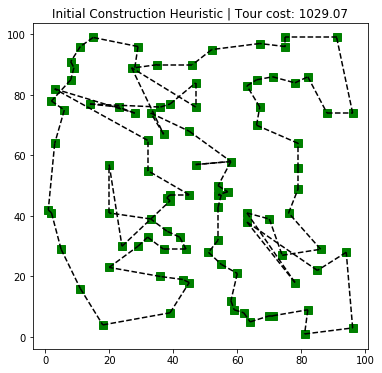

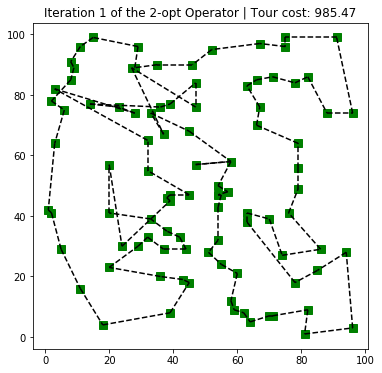

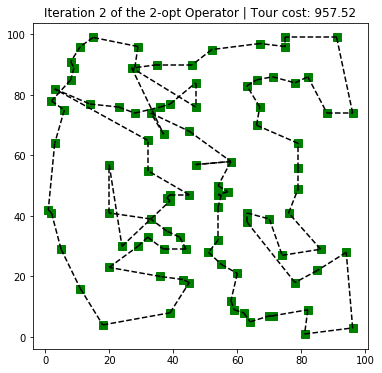

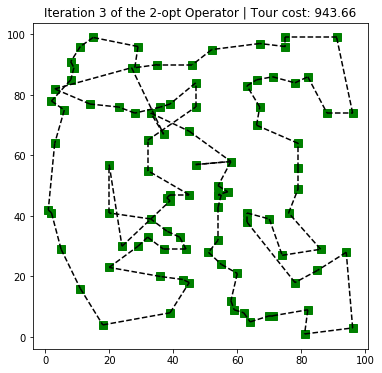

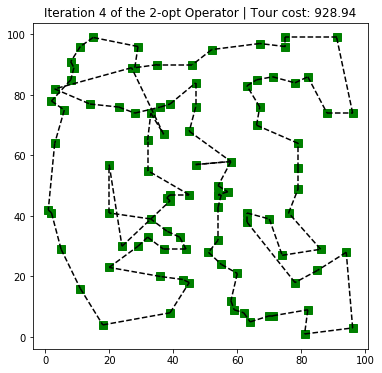

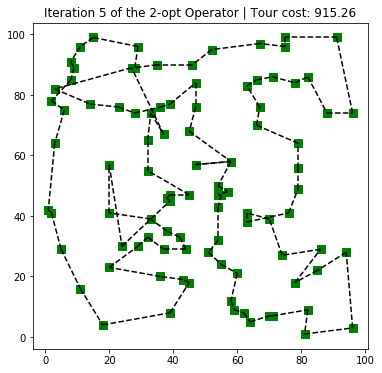

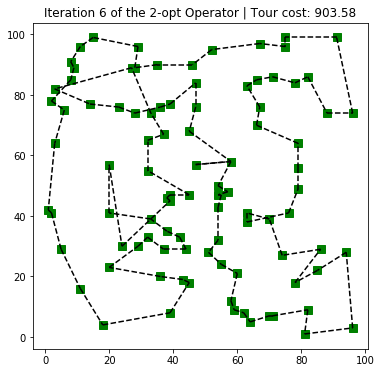

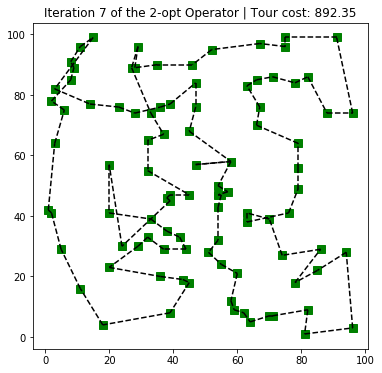

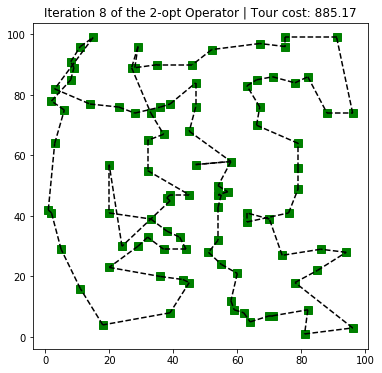

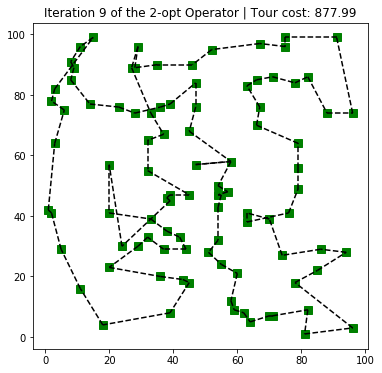

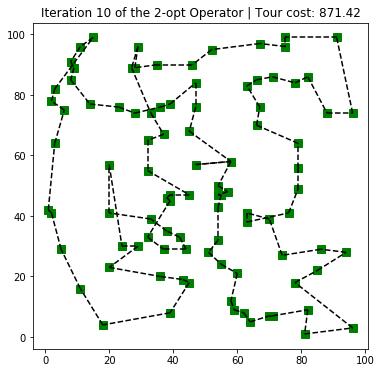

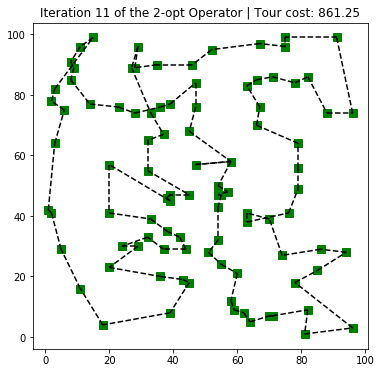

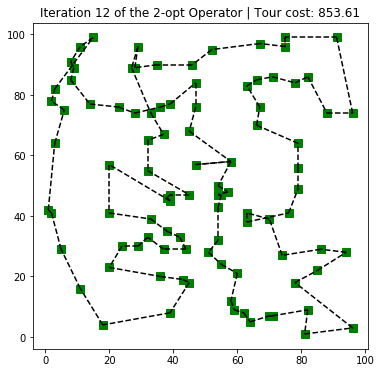

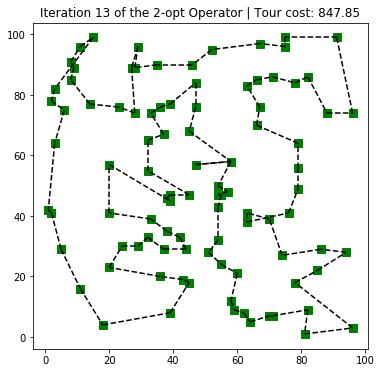

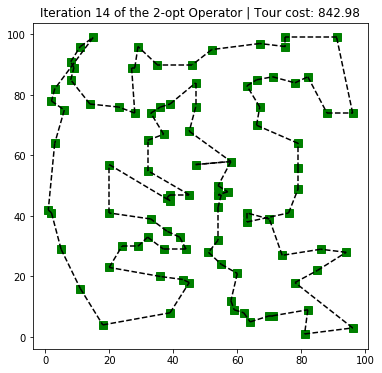

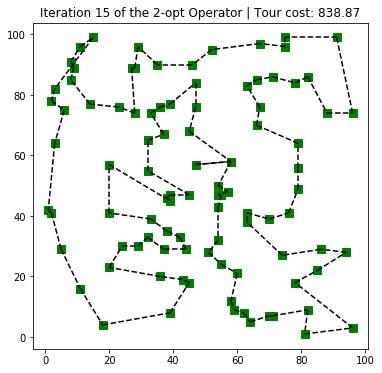

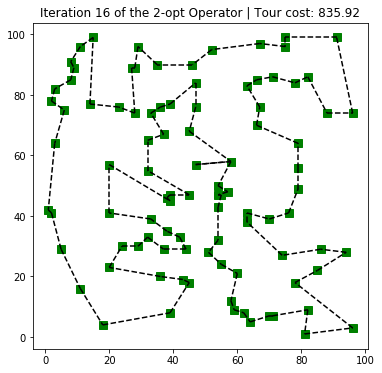

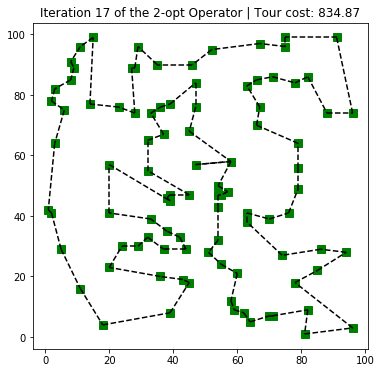

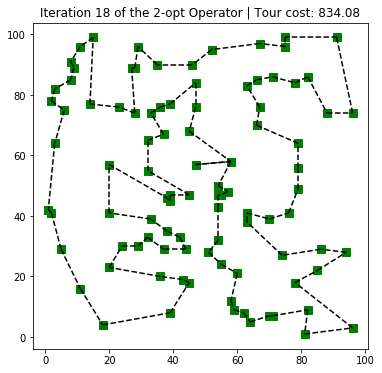

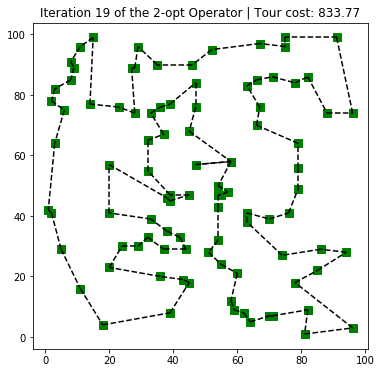

In [ ]:
plot_tour_costs = []

#node_loc = df_comparison_results.loc[0,'Instance']
#tour_improvement = df_twoopt_log.loc[0,'Tour_improvement']
#num_of_nodes = len(node_loc)

for plot_it in range(0,len(tour_improvement)-1):

    node_loc_x = np.array(node_loc).T[0]
    node_loc_y = np.array(node_loc).T[1]

    plt.figure(figsize=(6,6))
    plt.plot(node_loc_x, node_loc_y, 'gs', markersize=8)

    # Plotting the Nearest Neighbour Heuristic Solution
    def func_connect_points_TSP_NN(node_loc_x,node_loc_y,p1,p2):
        x1, x2 = node_loc_x[p1], node_loc_x[p2]
        y1, y2 = node_loc_y[p1], node_loc_y[p2]
        plt.plot([x1,x2],[y1,y2],'--k')

    for i in range(0,len(tour_improvement[0])-1):
        func_connect_points_TSP_NN(node_loc_x, node_loc_y, tour_improvement[plot_it][i],tour_improvement[plot_it][i+1])
    '''
    annotations = ['N-' + str(i) for i in range(0,num_of_nodes)]
    for i, label in enumerate(annotations):
        plt.annotate(label, (node_loc_x[i]+1, node_loc_y[i]+1))
    '''
    tour_cost = sum([df_dist.iloc[tour_improvement[plot_it][i],tour_improvement[plot_it][i+1]] for i in range(0,len(tour_improvement[0])-1)])
    plot_tour_costs.append(tour_cost)
    if plot_it == 0:
        plt.title('Initial Construction Heuristic | Tour cost: ' + "{:.2f}".format(tour_cost))
    else:
        plt.title('Iteration ' + str(plot_it) + ' of the 2-opt Operator | Tour cost: ' + "{:.2f}".format(tour_cost))

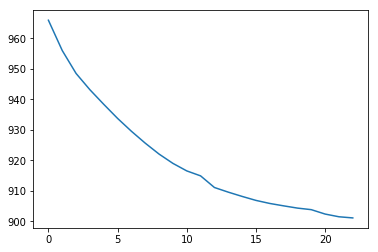

In [692]:
plt.plot(range(0,len(tour_improvement)-1),plot_tour_costs)

### Improving with 2 Opt our previous heuristics

In [26]:
# Here you can choose between the Nearest Neighbour, Savings or Christofides Heuristics
#construction_heuristic_solution = func_obtain_NN(df_dist)
df_twoopt_log = pd.DataFrame(data={'Instance':[],'Tour_improvement':[],'Gain_log':[],'Exec_Time':[]})
for i in range(0,len(df_comparison_results)):
    curr_solution = list(df_comparison_results.loc[i,'Tour'])
    curr_solution.insert(0,0)
    
    node_loc = df_comparison_results.loc[i,'Instance']
    num_of_nodes = len(node_loc)
    dist_list = func_dist_calc(node_loc)
    df_dist = pd.DataFrame(data=np.array(dist_list).reshape(num_of_nodes,num_of_nodes))
    df_dist.replace(to_replace=0.0,value=np.nan, inplace=True)

    begin_time = time.time()
    twoopt_solution = func_twoopt_operator(df_dist, curr_solution, search_type='best')
    exec_time = time.time()-begin_time
    tour_improvement = twoopt_solution[0]
    if len(tour_improvement[0])<(len(df_dist)+1):
        tour_improvement[0].append(tour_improvement[0][0])
        
    df_row = pd.Series(data=[i,tour_improvement, twoopt_solution[1],exec_time],
                      index=['Instance','Tour_improvement','Gain_log','Exec_Time'], name=None)
    df_twoopt_log = df_twoopt_log.append(df_row,ignore_index=True)

In [27]:
df_twoopt_log.tail()

,Instance,Tour_improvement,Gain_log,Exec_Time
283,283.0,"[[11, 32, 47, 50, 79, 14, 59, 55, 58, 74, 1, 3...","[-2.058031017540838, -1.4382273721453984, -0.5...",2.697893
284,284.0,"[[0, 4, 70, 7, 23, 6, 10, 77, 52, 60, 34, 80, ...","[-9.80666200321036, -7.416738513281077, -6.356...",14.534180
285,285.0,"[[81, 34, 90, 13, 84, 97, 55, 82, 59, 39, 66, ...","[-52.82461276626918, -19.777352053070622, -21....",14.152172
286,286.0,"[[12, 60, 42, 68, 69, 53, 25, 47, 16, 31, 32, ...","[-60.31995483914588, -18.345199209124146, -14....",10.205530
287,287.0,"[[0, 93, 96, 6, 37, 4, 22, 88, 58, 72, 56, 28,...","[-11.800033986864193, -13.090572805681568, -5....",12.713376


In [28]:
df_comparison_results = pd.merge(df_comparison_results, df_twoopt_log, left_index=True, right_index=True, how='left')
df_comparison_results.rename(columns={'Instance_x':'Instance','Exec_Time_x':'Exec_Time','Exec_Time_y':'Exec_Time_2Opt'}, inplace=True)
del(df_comparison_results['Instance_y'])

df_comparison_results['Performance_2Opt'] = 0
df_comparison_results['Iterations_2Opt'] = 0
for i in range(0,len(df_comparison_results)):
    #gain_mod = [np.float(x) for x in df_comparison_results.loc[i,'Gain_log'].replace('[','').replace(']','').split(',')]
    df_comparison_results.loc[i,'Performance_2Opt'] = df_comparison_results.loc[i,'Performance']+sum(df_comparison_results.loc[i,'Gain_log'])
    #df_comparison_results.loc[i,'Performance_2Opt'] = df_comparison_results.loc[i,'Performance']+sum(gain_mod)
    df_comparison_results.loc[i,'Iterations_2Opt'] = len(df_comparison_results.loc[i,'Gain_log'])-1
    #df_comparison_results.loc[i,'Iterations_2Opt'] = len(gain_mod)-1
    
df_comparison_results['Performance_Improvement'] = 1-(df_comparison_results['Performance_2Opt']/df_comparison_results['Performance'])

#df_comparison_results.to_pickle("df_comparison_results.pkl")

In [6]:
df_comparison_results = pd.read_pickle("df_comparison_results.pkl") 

In [7]:
df_comparison_results[['Iteration','Instance_Size','Algorithm','Performance','Exec_Time','Exec_Time_2Opt','Performance_2Opt','Iterations_2Opt','Performance_Improvement']].tail()

,Iteration,Instance_Size,Algorithm,Performance,Exec_Time,Exec_Time_2Opt,Performance_2Opt,Iterations_2Opt,Performance_Improvement
283,94.0,99.0,Savings,845.360440,0.570889,2.697893,841.303290,3,0.004799
284,94.0,99.0,Christofides,888.975025,0.522496,14.534180,813.995878,19,0.084343
285,95.0,100.0,NN,996.033202,0.054154,14.152172,818.374043,18,0.178367
286,95.0,100.0,Savings,994.339919,0.569728,10.205530,803.557688,15,0.191868
287,95.0,100.0,Christofides,NaN,0.731045,12.713376,NaN,16,NaN


Text(0.5, 1.0, 'Execution Time of 2 Opt Improvement vs Instance Size')

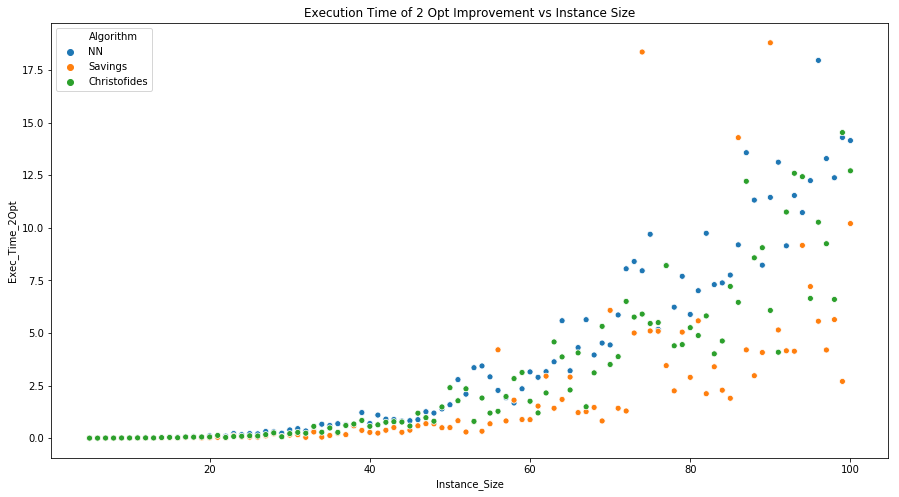

In [7]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=df_comparison_results, x='Instance_Size', y='Exec_Time_2Opt', hue='Algorithm')
plt.title('Execution Time of 2 Opt Improvement vs Instance Size')

Text(0.5, 1.0, 'Iterations of 2 Opt Improvement vs Instance Size')

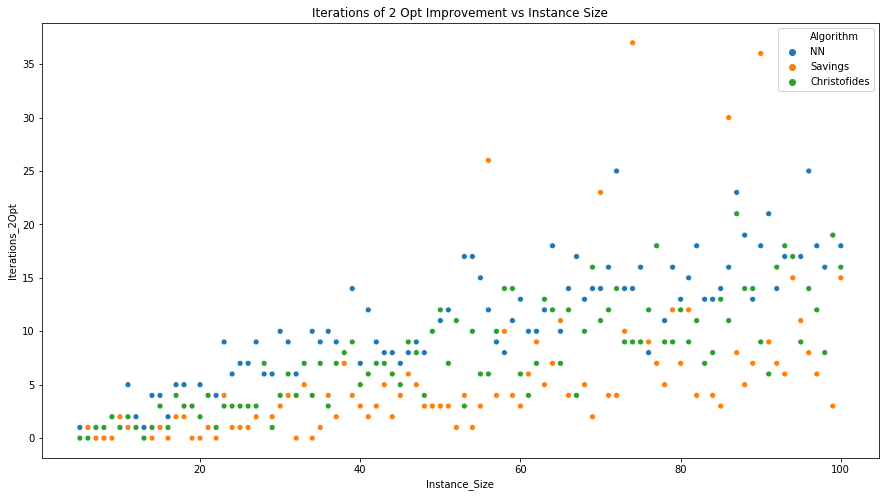

In [8]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=df_comparison_results, x='Instance_Size', y='Iterations_2Opt', hue='Algorithm')
plt.title('Iterations of 2 Opt Improvement vs Instance Size')

Text(0.5, 1.0, 'Performance Improvement of 2 Opt Improvement vs Instance Size')

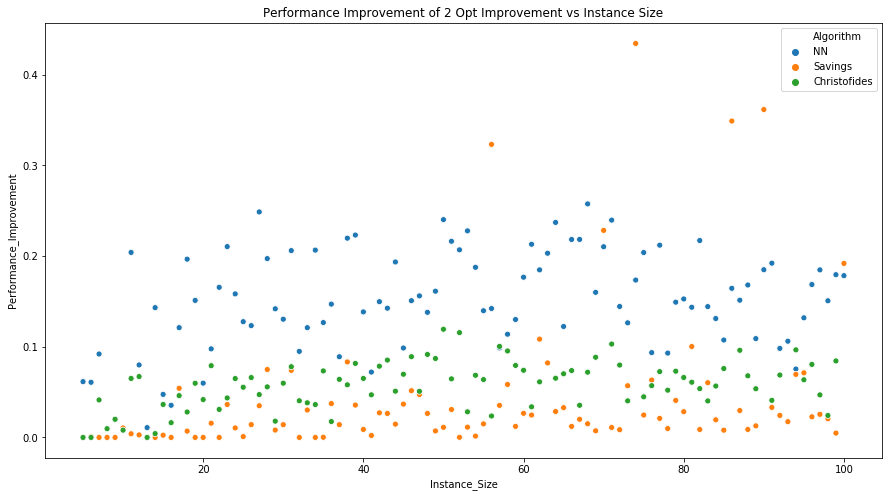

In [9]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=df_comparison_results, x='Instance_Size', y='Performance_Improvement', hue='Algorithm')
plt.title('Performance Improvement of 2 Opt Improvement vs Instance Size')

<Figure size 1080x576 with 0 Axes>

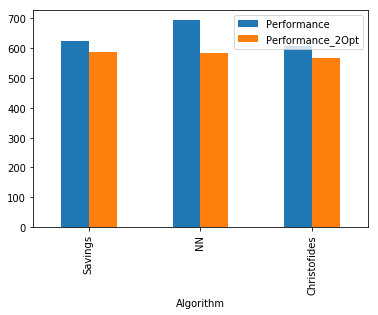

In [10]:
plt.figure(figsize=(15,8))
df_comparison_results[['Algorithm','Performance','Performance_2Opt']].groupby(by='Algorithm', as_index=False).mean().sort_values(by='Performance_2Opt', ascending=False).plot(x='Algorithm', y=['Performance','Performance_2Opt'], kind="bar")

## Genetic Algorithm

The following is an example of a generic single-objective genetic algorithm.

Step One: Generate the initial population of individuals randomly. (First generation)

Step Two: Repeat the following regenerational steps until termination:

1. Evaluate the fitness of each individual in the population (time limit, sufficient fitness achieved, etc.)
2. Select the fittest individuals for reproduction. (Parents)
3. Breed new individuals through crossover and mutation operations to give birth to offspring.
4. Replace the least-fit individuals of the population with new individuals.

### Order crossover operator (OX) 

In [2]:
# Define the size of the two crossover points (for example the length to be equal to some length of the problem (10%)) (x)
# Parent one could be the Christofides solution (x)
# Parent two could be the Savings solution (x)

In [8]:
# Function for creating 2 children out from two parents
def child_generation_ox(parent1, parent2, ox_length_percent):
#for it in [1]:    
    # "Shuffle" the original tour, so that regardless of where it originally began, we can have different nodes
    tour_size = len(parent1)
    slicer = random.randint(0,tour_size)
    parent1 = parent1[slicer:] + parent1[:slicer]
    parent2 = parent2[slicer:] + parent2[:slicer]
    
    # Hyperparameter could be the length of the OX operator
    ox_length = int(np.ceil(tour_size * ox_length_percent))
    
    # Beginning and end of the Order Crossover Operator
    ox_begin = int(random.randint(0,(tour_size-ox_length)-1))
    ox_end = int(ox_begin + ox_length)
    
    # Slicing the part of the parent tour that will be transferred to the other parent
    ox_parent1 = parent1[ox_begin:ox_end]
    ox_parent2 = parent2[ox_begin:ox_end]
    
    # Child 1 
    child1_temp = []
    adj_factor = 0
    for e,i in enumerate(parent1[:ox_begin] + parent1[ox_end:]):
        if i not in ox_parent2:
            child1_temp.append([e,i])
        else:
            adj_factor += 1 if e>=ox_begin else 0
    child1 = ox_parent2.copy()
    child1_temp_remove = []
    # How many places are left to the right?
    for i in range(0,tour_size-ox_end):
        if i < len(child1_temp):
            child1.append(child1_temp[-(tour_size-ox_end)+adj_factor+i][1])
            child1_temp_remove.append(child1_temp[-(tour_size-ox_end)+adj_factor+i])
        else:
            break
    for i in child1_temp_remove:
        child1_temp.remove(i)
        
    # Ensembling the final tour with its corresponding parts    
    child1 += (list(np.array(child1_temp).transpose()[1]) if len(child1_temp)>0 else list([]))+[x for x in ox_parent1 if x not in ox_parent2]

    # Child 2 
    child2_temp = []
    adj_factor = 0
    for e,i in enumerate(parent2[:ox_begin] + parent2[ox_end:]):
        if i not in ox_parent1:
            child2_temp.append([e,i])
        else:
            adj_factor += 1 if e>=ox_begin else 0
    child2 = ox_parent1.copy()
    child2_temp_remove = []
    # How many places are left to the right?
    for i in range(0,tour_size-ox_end):
        if i < len(child2_temp):
            child2.append(child2_temp[-(tour_size-ox_end)+adj_factor+i][1])
            child2_temp_remove.append(child2_temp[-(tour_size-ox_end)+adj_factor+i])
        else:
            break
    for i in child2_temp_remove:
        child2_temp.remove(i)
        
    # Ensembling the final tour with its corresponding parts     
    child2 += (list(np.array(child2_temp).transpose()[1]) if len(child2_temp)>0 else list([])) + [x for x in ox_parent2 if x not in ox_parent1]
    
    return child1, child2, slicer, ox_length, ox_begin, ox_end,

In [9]:
def child_edges_cost(child, df_dist):
    child_edges = [[child[i],child[i+1]] if i < len(child)-1 else [child[-1],child[0]] for i in range(0,len(child))]
    child_cost = [df_dist.loc[edge[0],edge[1]] for edge in child_edges]
    return child_edges, child_cost

#### Test instances OX Operator

In [252]:
parent1 = ['a','b','c','d','e','f','g','h','i','j']
parent2 = ['c','f','g','a','h','b','d','i','e','j']

tour_size = len(parent1)

ox_begin = 5
ox_end = 5+3

ox_parent1 = parent1[ox_begin:ox_end]
ox_parent2 = parent2[ox_begin:ox_end]

In [418]:
parent1 = [4,6,3,2,1,10,14,13,7,8,9,11,5,12]
parent2 = [5,9,13,1,8,3,2,12,6,14,11,4,10,7]

tour_size = len(parent1)

ox_begin = 6
ox_end = 6+5

ox_parent1 = parent1[ox_begin:ox_end]
ox_parent2 = parent2[ox_begin:ox_end]

In [584]:
parent1_temp = [i-1 for i in [4,6,3,2,1,10,14,13,7,8,9,11,5,12]]
parent2_temp = [i-1 for i in [5,9,13,1,8,3,2,12,6,14,11,4,10,7]]
# decimal between 0.20 and 0.80
ox_length_percent = 0.50
child_generation_ox(parent1_temp, parent2_temp, ox_length_percent)

([4, 8, 12, 0, 7, 2, 1, 6, 10, 11, 3, 5, 9, 13],
 [3, 5, 2, 1, 0, 9, 13, 11, 10, 6, 4, 8, 12, 7],
 12,
 7,
 2,
 9)

#### Experiment with existing heuristics solutions, on hold because the objective function is not improving

In [697]:
row = 112

parent1, parent2 = df_comparison_results.loc[row,'Tour'][1][:-1], df_comparison_results.loc[row+1,'Tour'][1][:-1]
parent1_cost, parent2_cost = df_comparison_results.loc[row,'Performance'], df_comparison_results.loc[row+1,'Performance']

print('Parent1: ', parent1, ' Cost: ' ,parent1_cost,
      '\nParent2: ', parent2, ' Cost: ' ,parent2_cost
     )

Parent1:  [7, 31, 2, 40, 27, 8, 32, 35, 39, 37, 15, 34, 38, 36, 0, 1, 13, 17, 5, 4, 14, 29, 22, 6, 25, 18, 26, 10, 20, 28, 41, 19, 3, 30, 23, 9, 21, 11, 12, 16, 33, 24]  Cost:  585.9302140869148 
Parent2:  [0, 1, 13, 34, 15, 38, 36, 26, 28, 20, 10, 5, 4, 14, 29, 22, 25, 6, 18, 19, 30, 23, 41, 9, 3, 21, 11, 16, 12, 33, 24, 7, 31, 2, 40, 27, 8, 32, 35, 37, 39, 17]  Cost:  596.5174378865469


In [698]:
ox_length_percent = 0.30
child1, child2 = child_generation_ox(parent1, parent2, ox_length_percent)[0:2]


## Taking the instance in form of nodes coordinates from df_comparison_results and calculating again its distance matrix since this was 
## not saved
num_of_nodes = len(df_comparison_results.loc[row,'Instance'])
node_loc = df_comparison_results.loc[row,'Instance']
dist_list = func_dist_calc(node_loc)
df_dist = pd.DataFrame(data=np.array(dist_list).reshape(num_of_nodes,num_of_nodes))
df_dist.replace(to_replace=0.0,value=np.nan, inplace=True)

child1_edges, child1_cost = child_edges_cost(child1, df_dist)
child2_edges, child2_cost = child_edges_cost(child2, df_dist)

print('Child1: ', child1, ' Cost: ' ,sum(child1_cost),
      '\nChild2: ', child2, ' Cost: ' ,sum(child2_cost)
     )

Child1:  [0, 1, 13, 34, 15, 38, 36, 26, 28, 20, 10, 5, 4, 17, 14, 29, 22, 6, 25, 18, 41, 19, 3, 30, 23, 9, 21, 11, 12, 16, 33, 24, 7, 31, 2, 40, 27, 8, 32, 35, 39, 37]  Cost:  673.5822235798285 
Child2:  [7, 31, 2, 40, 27, 8, 32, 35, 39, 37, 15, 34, 38, 14, 29, 22, 25, 6, 18, 19, 30, 23, 41, 9, 3, 21, 11, 16, 12, 33, 24, 17, 0, 1, 13, 36, 26, 28, 20, 10, 5, 4]  Cost:  721.18286744231


In [699]:
child = parent1
child_edges = [[child[i],child[i+1]] if i < len(child)-1 else [child[-1],child[0]] for i in range(0,len(child))]
child_cost = [df_dist.loc[edge[0],edge[1]] for edge in child_edges]

In [700]:
sum(child_cost)

585.9302140869147

#### Experiment with random generated tours

In [5]:
# Evaluate the costs from the new children (x)
# Allow them to proceed as parents if it is an improving solution
# Introduce some mutation either if the solutions is improving or has stopped improving

# Take the instance, destroy it and improve it since as of now there is no improving solution for the tests made

In [416]:
## Creation of a random instance that we will use across the different exercises ##
row = 60

num_of_nodes = len(df_comparison_results.loc[row,'Instance'])
node_loc = df_comparison_results.loc[row,'Instance']
dist_list = func_dist_calc(node_loc)
df_dist = pd.DataFrame(data=np.array(dist_list).reshape(num_of_nodes,num_of_nodes))
df_dist.replace(to_replace=0.0,value=np.nan, inplace=True)
df_dist.head(10)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,NaN,67.268120,70.604532,58.855756,83.630138,52.201533,96.829747,16.155494,72.062473,35.128336,...,89.944427,13.601471,72.718636,60.074953,66.189123,3.162278,90.088845,66.610810,80.448741,27.294688
1,67.268120,NaN,72.732386,8.544004,92.655275,65.192024,89.202018,54.424259,17.088007,34.885527,...,23.000000,62.769419,80.056230,17.088007,8.000000,66.940272,29.410882,53.366656,81.492331,80.622577
2,70.604532,72.732386,NaN,67.683085,19.924859,18.439089,26.248809,57.306195,60.415230,53.600373,...,82.927679,57.008771,7.810250,55.659680,65.192024,67.623960,70.092796,20.248457,10.440307,55.226805
3,58.855756,8.544004,67.683085,NaN,87.555697,58.591808,86.023253,45.880279,19.104973,26.419690,...,31.144823,54.230987,74.726167,13.152946,9.433981,58.463664,34.928498,49.162994,76.941536,72.201108
4,83.630138,92.655275,19.924859,87.555697,NaN,33.541020,23.021729,72.422372,80.056230,72.027772,...,102.215459,70.263789,13.038405,75.584390,85.094066,80.498447,88.600226,39.812058,12.727922,63.126856
5,52.201533,65.192024,18.439089,58.591808,33.541020,NaN,44.687806,39.395431,56.586217,39.204592,...,79.931220,38.600518,21.189620,48.600412,58.600341,49.203658,70.178344,23.194827,28.301943,38.078866
6,96.829747,89.202018,26.248809,86.023253,23.021729,44.687806,NaN,83.216585,73.979727,77.162167,...,93.605555,83.240615,26.076810,73.000000,81.221918,93.861600,78.000000,37.483330,17.204651,80.603970
7,16.155494,54.424259,57.306195,45.880279,72.422372,39.395431,83.216585,NaN,57.078893,20.223748,...,76.400262,8.602325,60.539243,45.099889,52.172790,14.317821,75.026662,51.088159,67.535176,28.319605
8,72.062473,17.088007,60.415230,19.104973,80.056230,56.586217,73.979727,57.078893,NaN,37.000000,...,23.345235,64.498062,68.095521,12.000000,10.000000,71.000000,18.027756,40.249224,68.154237,79.699435
9,35.128336,34.885527,53.600373,26.419690,72.027772,39.204592,77.162167,20.223748,37.000000,NaN,...,56.320511,28.160256,59.076222,25.000000,32.015621,34.000000,55.009090,40.706265,63.953108,45.793013


In [16]:
parent1 = [i for i in range(0,num_of_nodes)]
random.shuffle(parent1)
parent2 = [i for i in range(0,num_of_nodes)]
random.shuffle(parent2)

In [17]:
parent1_edges, parent1_cost = child_edges_cost(parent1, df_dist)
parent2_edges, parent2_cost = child_edges_cost(parent2, df_dist)

sum(parent1_cost), sum(parent2_cost)

(1243.9393337167608, 1445.5861962500542)

In [18]:
ox_length_percent = 0.30
child1, child2 = child_generation_ox(parent1, parent2, ox_length_percent)[0:2]

child1_edges, child1_cost = child_edges_cost(child1, df_dist)
child2_edges, child2_cost = child_edges_cost(child2, df_dist)

print('Child1: ', child1, ' Cost: ' ,sum(child1_cost),
      '\nChild2: ', child2, ' Cost: ' ,sum(child2_cost)
     )

Child1:  [11, 8, 17, 7, 21, 20, 6, 4, 9, 10, 18, 5, 19, 15, 22, 13, 1, 16, 3, 24, 0, 12, 2, 14, 23]  Cost:  1251.3612742138623 
Child2:  [20, 24, 7, 0, 12, 2, 14, 23, 15, 16, 19, 5, 22, 13, 3, 9, 10, 18, 1, 11, 8, 17, 21, 6, 4]  Cost:  1135.644629122065


In [19]:
# How many generations of offspring do you want?
generations = 13
for generation in range(0,generations+1):

    if generation == 0:
        # Creating the pool of parents
        num_of_couples = int(2**(generations+1))
        parent_pool = []
        parent_pool_temp = []
        for i in range(0,num_of_couples*2):
            parent = [i for i in range(0,num_of_nodes)]
            random.shuffle(parent)
            parent_edges, parent_cost = child_edges_cost(parent, df_dist)
            parent_pool_temp.append([generation, [0,0], parent, sum(parent_cost), parent_edges])
        parent_pool.append(parent_pool_temp)
    else:
        pass

    # randomly matching the parents:
    matchings = [x for x in range(0,int(num_of_couples))]
    random.shuffle(matchings)
    matchings = np.reshape(np.array(matchings),(int((num_of_couples/2)),2))
    
    # Child add descriptions
    child_pool = []
    for matching in matchings:
        #print(matching, parent_pool[generation][matching[0]][2], parent_pool[generation][matching[1]][2], )
        ox_length_percent = 0.30
        child1, child2 = child_generation_ox(parent_pool[generation][matching[0]][2], 
                                             parent_pool[generation][matching[1]][2], 
                                             ox_length_percent)[0:2]
        child1_edges, child1_cost = child_edges_cost(child1, df_dist)
        child2_edges, child2_cost = child_edges_cost(child2, df_dist)
        child_pool.append([generation+1, matching, child1, sum(child1_cost), child1_edges])
        child_pool.append([generation+1, matching, child2, sum(child2_cost), child2_edges])

    parent_pool_temp = np.array(child_pool, dtype=list)[np.array(child_pool, dtype=list)[:,3].argsort(kind='heap')][0:int((num_of_couples/2))]
    parent_pool.append(parent_pool_temp)
    num_of_couples /= 2

In [20]:
df_ga = pd.DataFrame(data={'Generation':[],'Matching':[],'Parent':[],'Performance':[],'Edges':[]})
for i in range(0,generations+1):     
    df_ga = pd.concat([df_ga,pd.DataFrame(data=parent_pool[i], columns=['Generation','Matching','Parent','Performance','Edges'])])
    
df_ga['Performance'] = df_ga['Performance'].astype('float')
df_ga.reset_index(inplace=True, drop=True)
df_ga_plot = df_ga[['Generation','Performance']].groupby(by='Generation', as_index=False).mean()

Text(0.5, 0, 'Generation')

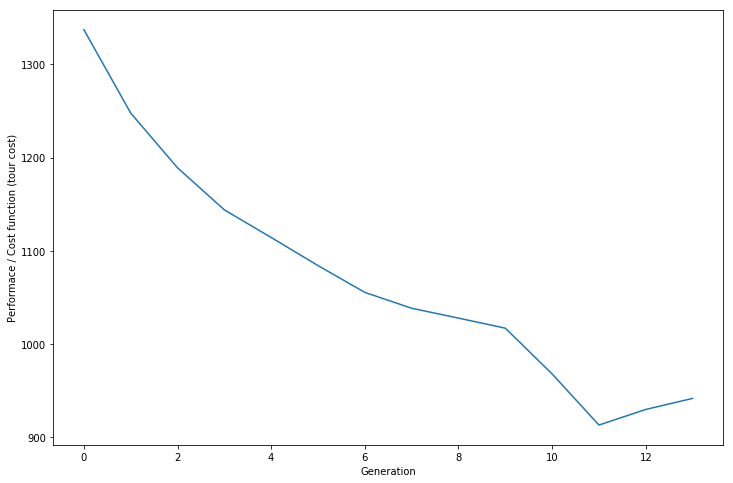

In [21]:
plt.figure(figsize=(12,8))
plt.plot(df_ga_plot['Generation'], df_ga_plot['Performance'])
plt.ylabel('Performace / Cost function (tour cost)')
plt.xlabel('Generation')

In [22]:
df_ga_plot

,Generation,Performance
0,0.0,1337.328638
1,1.0,1247.827989
2,2.0,1189.091074
3,3.0,1143.957033
4,4.0,1114.314327
5,5.0,1084.165007
6,6.0,1055.399009
7,7.0,1038.381744
8,8.0,1027.804007
9,9.0,1016.992114


In [24]:
len(df_ga)

49150

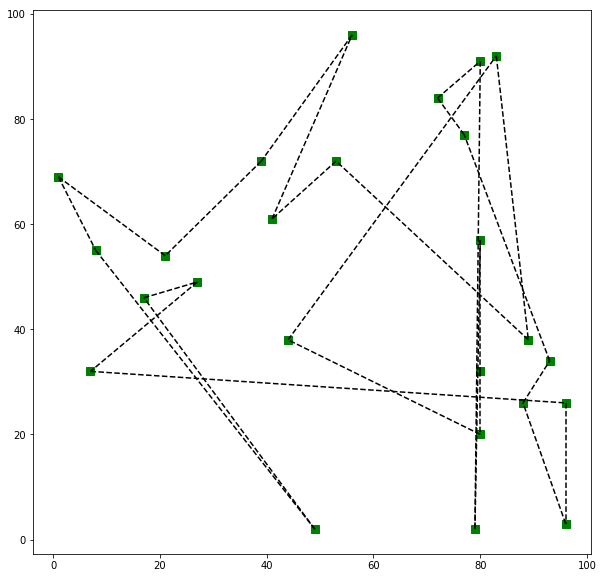

In [25]:
#ga_results = [x[0] for x in df_ga.loc[196605,'Edges']] + [df_ga.loc[196605,'Edges'][0][0]]
ga_results = [x[0] for x in df_ga.loc[49140,'Edges']] + [df_ga.loc[49140,'Edges'][0][0]]

node_loc_x = np.array(node_loc).T[0]
node_loc_y = np.array(node_loc).T[1]

plt.figure(figsize=(10,10))
plt.plot(node_loc_x, node_loc_y, 'gs', markersize=8)

# Plotting the Nearest Neighbour Heuristic Solution
def func_connect_points_TSP_NN(node_loc_x,node_loc_y,p1,p2):
    x1, x2 = node_loc_x[p1], node_loc_x[p2]
    y1, y2 = node_loc_y[p1], node_loc_y[p2]
    plt.plot([x1,x2],[y1,y2],'--k')

for i in range(0,len(ga_results)-1):
    func_connect_points_TSP_NN(node_loc_x, node_loc_y, ga_results[i],ga_results[i+1])

#### What would happen if we introduce some strong individuals such as our best solutions into a chaotic(random) generated population?

In [56]:
# Obtaining the fit individuals

parent_pool_fit = []
# First obtaining the original solutions for the NN, Savings and Christofides Solutions 
parent_pool_fit_tours = [x[1][0:-1] for x in df_comparison_results[df_comparison_results['Instance_Size']==num_of_nodes]['Tour']]
parent_pool_fit_costs = [x for x in df_comparison_results[df_comparison_results['Instance_Size']==num_of_nodes]['Performance']]
parent_pool_fit_edges = []
for x in parent_pool_fit_tours:
    #parent_pool_fit_edges.append([y if e<len(x) else x[0] for e,y in enumerate(x)])
    edges_temp = [[x[e],x[e+1]] for e,y in enumerate(x[0:-1])]
    edges_temp.append([x[-1],x[0]])
    parent_pool_fit_edges.append(edges_temp)
parent_pool_fit += [[0,[0,0],parent_pool_fit_tours[x],parent_pool_fit_costs[x],parent_pool_fit_edges[x]] for x in range(0,len(parent_pool_fit_tours))]


# Secondly obtaining the 3 corresponding 2 Opt improvements of the above instances in order to introduce new fit individuals
parent_pool_fit_tours = [x[-1][0:-1] for x in df_comparison_results[df_comparison_results['Instance_Size']==num_of_nodes]['Tour_improvement']]
parent_pool_fit_costs = [x for x in df_comparison_results[df_comparison_results['Instance_Size']==num_of_nodes]['Performance_2Opt']]
for x in parent_pool_fit_tours:
    #parent_pool_fit_edges.append([y if e<len(x) else x[0] for e,y in enumerate(x)])
    edges_temp = [[x[e],x[e+1]] for e,y in enumerate(x[0:-1])]
    edges_temp.append([x[-1],x[0]])
    parent_pool_fit_edges.append(edges_temp)
parent_pool_fit += [[0,[0,0],parent_pool_fit_tours[x],parent_pool_fit_costs[x],parent_pool_fit_edges[x]] for x in range(0,len(parent_pool_fit_tours))]

In [32]:
# How many generations of offspring do you want?
generations = 13
for generation in range(0,generations+1):

    if generation == 0:
        # Creating the pool of parents
        num_of_couples = int(2**(generations+1))
        parent_pool = []
        parent_pool_temp = []
        for i in range(0,num_of_couples*2):
            parent = [i for i in range(0,num_of_nodes)]
            random.shuffle(parent)
            parent_edges, parent_cost = child_edges_cost(parent, df_dist)
            parent_pool_temp.append([generation, [0,0], parent, sum(parent_cost), parent_edges])
        parent_pool.append(parent_pool_temp)
        print(len(parent_pool[0]))
        # Introducing fit parents if required
        if len(parent_pool_fit)>0:
            # Deleting the equal number of random parents
            for r in range(0,np.int(np.floor(((num_of_couples*2)*0.05)))):
                del parent_pool[0][0:len(parent_pool_fit)]
                parent_pool[0] += parent_pool_fit
            
    else:
        pass

    # randomly matching the parents:
    matchings = [x for x in range(0,int(num_of_couples))]
    random.shuffle(matchings)
    matchings = np.reshape(np.array(matchings),(int((num_of_couples/2)),2))
    
    # Child add descriptions
    child_pool = []
    for matching in matchings:
        #print(matching, parent_pool[generation][matching[0]][2], parent_pool[generation][matching[1]][2], )
        ox_length_percent = 0.30
        child1, child2 = child_generation_ox(parent_pool[generation][matching[0]][2], 
                                             parent_pool[generation][matching[1]][2], 
                                             ox_length_percent)[0:2]
        child1_edges, child1_cost = child_edges_cost(child1, df_dist)
        child2_edges, child2_cost = child_edges_cost(child2, df_dist)
        child_pool.append([generation+1, matching, child1, sum(child1_cost), child1_edges])
        child_pool.append([generation+1, matching, child2, sum(child2_cost), child2_edges])

    parent_pool_temp = np.array(child_pool, dtype=list)[np.array(child_pool, dtype=list)[:,3].argsort(kind='heap')][0:int((num_of_couples/2))]
    parent_pool.append(parent_pool_temp)
    num_of_couples /= 2

32768


In [33]:
df_ga2 = pd.DataFrame(data={'Generation':[],'Matching':[],'Parent':[],'Performance':[],'Edges':[]})
for i in range(0,generations+1):     
    df_ga2 = pd.concat([df_ga2,pd.DataFrame(data=parent_pool[i], columns=['Generation','Matching','Parent','Performance','Edges'])])
    
df_ga2['Performance'] = df_ga2['Performance'].astype('float')
df_ga2.reset_index(inplace=True, drop=True)
df_ga2_plot = df_ga2[['Generation','Performance']].groupby(by='Generation', as_index=False).mean()

Text(0.5, 0, 'Generation')

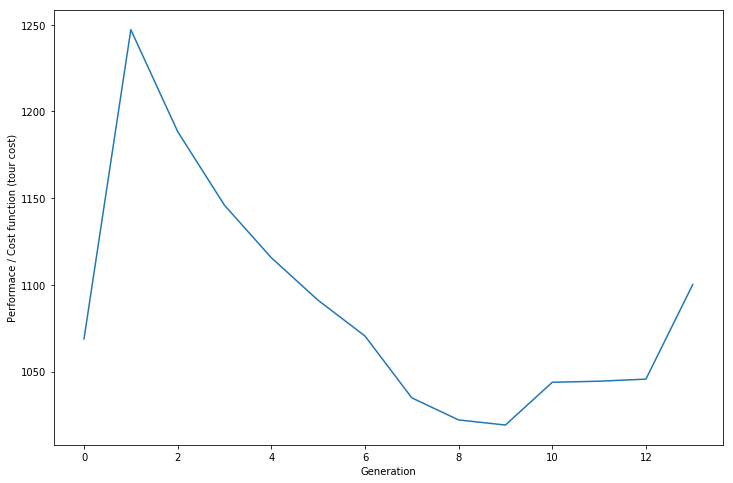

In [34]:
plt.figure(figsize=(12,8))
plt.plot(df_ga2_plot['Generation'], df_ga2_plot['Performance'])
plt.ylabel('Performace / Cost function (tour cost)')
plt.xlabel('Generation')

In [35]:
df_ga_plot['GA_Type'] = 'Random_Indivs'
df_ga2_plot['GA_Type'] = 'Random_+_Fit_Indivs'
df_ga_plot = pd.concat([df_ga_plot,df_ga2_plot])

Text(0.5, 0, 'Generation')

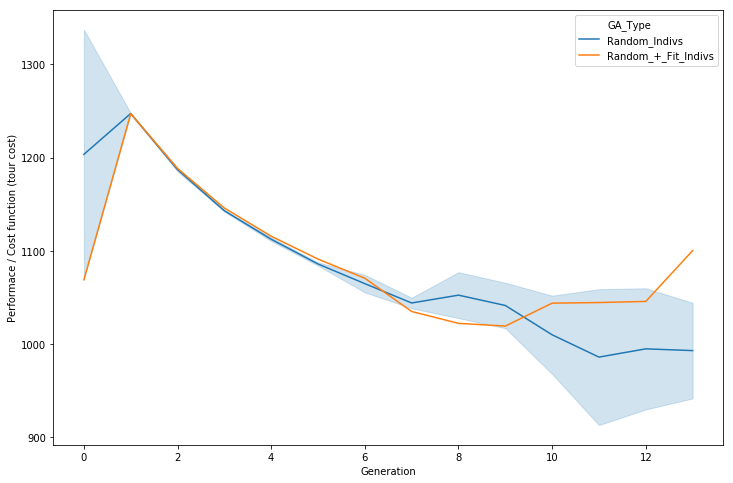

In [36]:
plt.figure(figsize=(12,8))
sns.lineplot(data=df_ga_plot, x='Generation',y='Performance',hue='GA_Type')
plt.ylabel('Performace / Cost function (tour cost)')
plt.xlabel('Generation')

#### Adjusting the children that go into the next generation

In [10]:
#population = 1000
#population *=0.99
population = 86.1
population = np.ceil(population) if np.ceil(population)%2==0 else np.ceil(population)+1
population

88.0

In [348]:
# Binary search subroutine for determining which child will pass on to the next generation according to its weight value:
def binary_search(num_to_search, weights_cumul):
    weights_cumul_temp = weights_cumul.copy()
    index = [i for i in range(0,len(weights_cumul_temp))]
    while len(weights_cumul_temp)>1:
        pos = int(np.floor(len(weights_cumul_temp)/2))
        if num_to_search < weights_cumul_temp[pos]:
            weights_cumul_temp = weights_cumul_temp[0:pos]
            index = index[0:pos]
        else:
            weights_cumul_temp = weights_cumul_temp[pos:]
            index = index[pos:]
    return int(index[0]), weights_cumul_temp

In [426]:
# Parameters: initial_population, decay_value, strictness, ox_length_percent
# At which rate do you want the population to decay?
init_population = 1000
population = init_population
generation = 0
while population>20:
#for iteration in range(0,50):    
    # Creating the initial pool of parents and introducing fit individuals if required
    if population == init_population:
        # Creating the pool of parents 
        parent_pool = []
        parent_pool_temp = []
        for i in range(0,population):
            parent = [i for i in range(0,num_of_nodes)]
            random.shuffle(parent)
            parent_edges, parent_cost = child_edges_cost(parent, df_dist)
            parent_pool_temp.append([generation, [0,0], parent, sum(parent_cost), parent_edges])
        parent_pool.append(parent_pool_temp)
        
        print(len(parent_pool[0]))
        # Introducing fit parents if required
        if 'parent_pool_fit' in locals():
            # Deleting the equal number of random parents
            for r in range(0,np.int(np.floor((init_population*0.05)))):
                del parent_pool[0][0:len(parent_pool_fit)]
                parent_pool[0] += parent_pool_fit
                
    else:
        pass
    
    # randomly matching the parents:
    matchings = [x for x in range(0,int(population))]
    random.shuffle(matchings)
    matchings = np.reshape(np.array(matchings),(int((population/2)),2))
    
    # Child add descriptions
    child_pool = []
    for matching in matchings:
        #print(matching, parent_pool[generation][matching[0]][2], parent_pool[generation][matching[1]][2], )
        ox_length_percent = 0.30
        child1, child2 = child_generation_ox(parent_pool[generation][matching[0]][2], 
                                             parent_pool[generation][matching[1]][2], 
                                             ox_length_percent)[0:2]
        child1_edges, child1_cost = child_edges_cost(child1, df_dist)
        child2_edges, child2_cost = child_edges_cost(child2, df_dist)
        child_pool.append([generation+1, matching, child1, sum(child1_cost), child1_edges])
        child_pool.append([generation+1, matching, child2, sum(child2_cost), child2_edges])
    child_pool = np.array(child_pool, dtype=list)[np.array(child_pool, dtype=list)[:,3].argsort(kind='heap')]
    
    # Updating generation and population values, forcing population to be an even number to ensure that matchings are made without problems
    population*=0.98
    population = np.floor(population) if np.floor(population)%2== 0 else np.floor(population)-1
    generation += 1
    
    # Obtaining the fittest individuals for the new generation
    child_pool_temp = []
    # 1.Original approach: this objective evaluation may incurr in higher costs because the new children may not necessarilly all be improving
    # 1.solutions over the last generation
    #child_pool_avg_obj = np.average(np.array(child_pool, dtype=list)[:,3])*strictness
    # 2.Modified approach: with this objective evaluation we force it to always be better than the average of the previous generation
    child_pool_avg_obj = np.average(np.array([i[3] for i in parent_pool[generation-1]]))*strictness
    # 3.Mixture approach: taking whatever results less between both objective evaluations
    #child_pool_avg_obj = min(np.average(np.array([i[3] for i in parent_pool[generation-1]]))*strictness,np.average(np.array(child_pool, dtype=list)[:,3])*strictness)
    for child in child_pool:
        if child[3] <= child_pool_avg_obj:
            child_pool_temp.append(child)
            #print(f'{child[3]:.2f}','--',f'{np.average(np.array(child_pool, dtype=list)[:,3])*strictness:.2f}','--',f'{1/child[3]:.8f}')
        else:
            break

    # Creating 
    # Give a proper name to this parameter, which itself says how strong do we want the best solutions to be part of the new child pool,
    # it is recommended between 1 and 100
    nameless_param = 80
    weight_total = sum([1/((child[3]+nameless_param)-(np.array(child_pool_temp, dtype=list)[:,3][0])) for child in child_pool_temp])
    weights = [(1/((child[3]+nameless_param)-(np.array(child_pool_temp, dtype=list)[:,3][0])))/weight_total for child in child_pool_temp]

    # Making a cumulative weight list, which will help us later for the sampling of the fittest individuals
    curr_weight = weights[0]
    weights_cumul = [weights[0]]
    for weight in weights[1:]:
        curr_weight += weight
        weights_cumul.append(curr_weight)

    # How many places do we have still free in our child pool for the next generation?
    no_of_samples = int(population) - int(len(child_pool_temp))
    print(population,'--',len(child_pool_temp),'--',no_of_samples)
    
    # Sampling from a f distribution and rescaling it, this sampling will resemble a probability distribution were the fittest individuals are
    # chosen more often than those that are worse
    samples = np.random.f(9,20,no_of_samples)
    max_sample = max(samples)
    samples = [sample/max_sample for sample in samples]
    child_indexes = [binary_search(sample,weights_cumul)[0] for sample in samples]

    parent_pool_temp = child_pool_temp.copy()
    for i in child_indexes:
        parent_pool_temp.append(child_pool_temp[i])
        
    parent_pool.append(parent_pool_temp)

1000
980.0 -- 516 -- 464
960.0 -- 356 -- 604
940.0 -- 299 -- 641
920.0 -- 219 -- 701
900.0 -- 147 -- 753
882.0 -- 106 -- 776
864.0 -- 78 -- 786
846.0 -- 78 -- 768
828.0 -- 71 -- 757
810.0 -- 101 -- 709
792.0 -- 109 -- 683
776.0 -- 133 -- 643
760.0 -- 110 -- 650
744.0 -- 105 -- 639
728.0 -- 197 -- 531
712.0 -- 14 -- 698
696.0 -- 502 -- 194
682.0 -- 9 -- 673


IndexError: list index out of range

In [427]:
# Printing performance results
for i in parent_pool:
    performances = []
    for e in i:
        performances.append(e[3])
    print(f'{np.average(np.array(performances)):.2f}','--',f'{min(performances):.2f}')

1340.25 -- 975.60
1195.33 -- 947.64
1077.17 -- 892.61
968.77 -- 841.69
854.63 -- 732.46
756.78 -- 692.16
696.75 -- 645.29
658.14 -- 605.87
617.89 -- 588.76
575.55 -- 545.67
547.23 -- 520.73
522.89 -- 506.02
510.36 -- 487.58
498.10 -- 487.90
487.65 -- 485.63
485.85 -- 477.98
474.72 -- 474.15
474.12 -- 473.44
473.44 -- 473.44


In [421]:
df_comparison_results.iloc[62]

Iteration                                                                 20
Instance_Size                                                             25
Instance                   [[83, 92], [96, 26], [27, 49], [93, 34], [8, 5...
Algorithm                                                       Christofides
Performance                                                          450.473
Exec_Time                                                          0.0937498
Tour                       ([[0, 20], [20, 16], [16, 7], [7, 9], [9, 10],...
Tour_improvement           [[0, 20, 16, 7, 9, 10, 3, 1, 19, 18, 8, 21, 15...
Gain_log                   [-11.693158411635082, -9.013844131756848, -4.2...
Exec_Time_2Opt                                                      0.111709
Performance_2Opt                                                     425.543
Iterations_2Opt                                                            3
Performance_Improvement                                            0.0553418

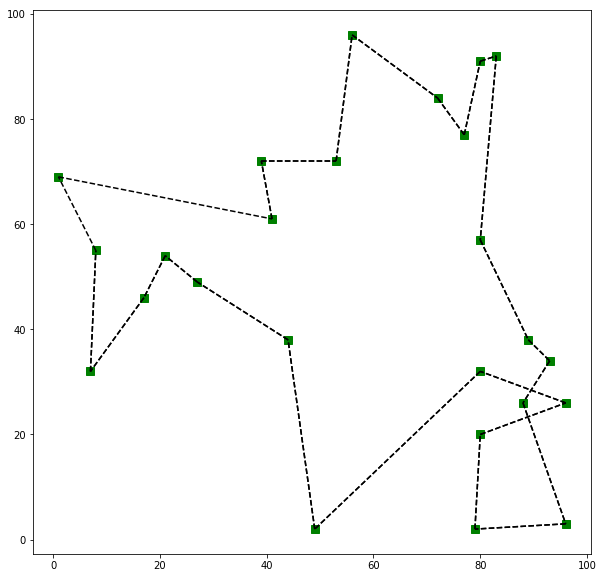

In [428]:
ga_results = parent_pool[-1][0][4]

node_loc_x = np.array(node_loc).T[0]
node_loc_y = np.array(node_loc).T[1]

plt.figure(figsize=(10,10))
plt.plot(node_loc_x, node_loc_y, 'gs', markersize=8)

# Plotting the Nearest Neighbour Heuristic Solution
def func_connect_points_TSP_NN(node_loc_x,node_loc_y,p1,p2):
    x1, x2 = node_loc_x[p1], node_loc_x[p2]
    y1, y2 = node_loc_y[p1], node_loc_y[p2]
    plt.plot([x1,x2],[y1,y2],'--k')

for i in range(0,len(ga_results)-1):
    func_connect_points_TSP_NN(node_loc_x, node_loc_y, ga_results[i],ga_results[i+1])

In [347]:
# Selecting only those improving children
child_pool_temp = []
child_pool_avg_obj = np.average(np.array(child_pool, dtype=list)[:,3])*strictness
for child in child_pool:
    if child[3] <= child_pool_avg_obj:
        child_pool_temp.append(child)
        #print(f'{child[3]:.2f}','--',f'{np.average(np.array(child_pool, dtype=list)[:,3])*strictness:.2f}','--',f'{1/child[3]:.8f}')
    else:
        break

# Creating 
# Give a proper name to this parameter, which itself says how strong do we want the best solutions to be part of the new child pool,
# it is recommended between 1 and 100
nameless_param = 80
weight_total = sum([1/((child[3]+nameless_param)-(np.array(child_pool_temp, dtype=list)[:,3][0])) for child in child_pool_temp])
weights = [(1/((child[3]+nameless_param)-(np.array(child_pool_temp, dtype=list)[:,3][0])))/weight_total for child in child_pool_temp]

# Making a cumulative weight list, which will help us later for the sampling of the fittest individuals
curr_weight = weights[0]
weights_cumul = [weights[0]]
for weight in weights[1:]:
    curr_weight += weight
    weights_cumul.append(curr_weight)
    
# How many places do we have still free in our child pool for the next generation?
no_of_samples = population - len(child_pool_temp)

# Sampling from a f distribution and rescaling it, this sampling will resemble a probability distribution were the fittest individuals are
# chosen more often than those that are worse
samples = np.random.f(9,20,no_of_samples)
max_sample = max(samples)
samples = [sample/max_sample for sample in samples]
child_indexes = [binary_search(sample,weights_cumul)[0] for sample in samples]

parent_pool_temp = child_pool_temp.copy()
for i in child_indexes:
    parent_pool_temp.append(child_pool_temp[i])
    
print(len(parent_pool_temp))

100


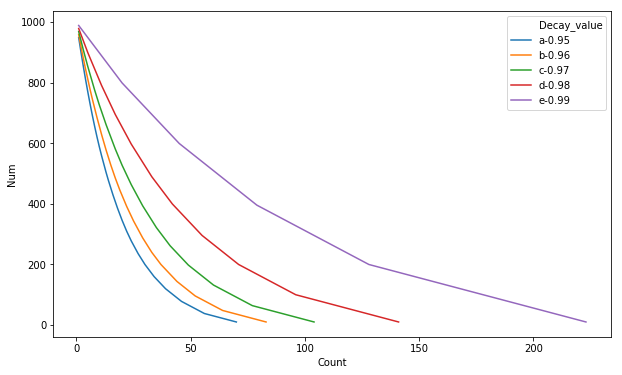

In [42]:
df_pop = pd.DataFrame(data={'ID_DV':[],'Decay_value':[],'Count':[],'Num':[]})
hues = ['a-0.95','b-0.96','c-0.97','d-0.98','e-0.99']
for e,dv in enumerate(np.linspace(0.95,0.99,5)):
    num = 1000
    count = 0
    while num>10:
        num*=np.float(dv)
        num = np.floor(num) if np.floor(num)%2== 0 else np.floor(num)-1
        count+=1
        df_row = pd.Series(data=[e, hues[e], count, num],
                           index=['ID_DV','Decay_value','Count','Num'], name=None)
        df_pop = df_pop.append(df_row,ignore_index=True)
        
plt.figure(figsize=(10,6))
sns.lineplot(data=df_pop, x='Count', y='Num', hue='Decay_value', palette='tab10')